In [1]:
!pip install CausalInference
!pip install pycountry

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 3.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.1 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681845 sha256=a44951feb8254dd0a9382e01ba0e1b5cb4842f58cd57fc635ec00ca1b3ed033c
  Stored in directory: /root/.cache/pip/wheels/0e/06/e8/7ee176e95ea9a8a8c3b3afcb1869f20adbd42413d4611c6eb4
Successfully built pycountry


## Imports and Constants

In [2]:
# Imports
from typing import Dict, List, Tuple, Any, Optional, Union
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

import pycountry
from causalinference import CausalModel

sns.set_style("whitegrid")

In [3]:
# Constants
DATA_PATH = "ds_salaries.csv"
FIGURES_PATH = "figures"
if not os.path.exists(FIGURES_PATH):
    os.makedirs(FIGURES_PATH)

COVARIATES_COLS = ["work_year", "employment_type", "job_title", "employee_residence", "remote_ratio", "company_location", "company_size"]
OUTCOME_COL = ["salary_in_usd"]
TREATMENT_COL = ["experience_level"]
USED_COLS = COVARIATES_COLS + OUTCOME_COL + TREATMENT_COL

LEVELS = ["EN", "MI", "SE", "EX"]  # all experience levels
LOW_LEVEL = [["EN"], ["EN", "MI"], ["EN", "MI", "SE"]]  # for the treatment, the low experience level
HIGH_LEVEL = [["MI", "SE", "EX"], ["SE", "EX"], ["EX"]]  # for the treatment, the high experience level

np.random.seed(42)

## Data Pre-process and Analysis

In [4]:
# Loading the data
data = pd.read_csv(DATA_PATH, usecols=USED_COLS)
data

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,US,100,US,M
603,2022,SE,FT,Data Engineer,126000,US,100,US,M
604,2022,SE,FT,Data Analyst,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,US,100,US,M


In [5]:
# The job titles in the raw data
raw_job_titles = data['job_title'].unique()
print(f"Before grouping we have {len(raw_job_titles)} job titles:\n{raw_job_titles}")

Before grouping we have 50 job titles:
['Data Scientist' 'Machine Learning Scientist' 'Big Data Engineer'
 'Product Data Analyst' 'Machine Learning Engineer' 'Data Analyst'
 'Lead Data Scientist' 'Business Data Analyst' 'Lead Data Engineer'
 'Lead Data Analyst' 'Data Engineer' 'Data Science Consultant'
 'BI Data Analyst' 'Director of Data Science' 'Research Scientist'
 'Machine Learning Manager' 'Data Engineering Manager'
 'Machine Learning Infrastructure Engineer' 'ML Engineer' 'AI Scientist'
 'Computer Vision Engineer' 'Principal Data Scientist'
 'Data Science Manager' 'Head of Data' '3D Computer Vision Researcher'
 'Data Analytics Engineer' 'Applied Data Scientist'
 'Marketing Data Analyst' 'Cloud Data Engineer' 'Financial Data Analyst'
 'Computer Vision Software Engineer' 'Director of Data Engineering'
 'Data Science Engineer' 'Principal Data Engineer'
 'Machine Learning Developer' 'Applied Machine Learning Scientist'
 'Data Analytics Manager' 'Head of Data Science' 'Data Specialis

In [6]:
# Create the pre-process DataFrame
processed_data = data.copy()

# We have many sub job titles, we convert all of them to 5 main job titles:
# Data Scientist, Data Engineer, Data Analyst, Machine Learning Engineer and Research Scientist
job_titles_mapping = {
    "Data Scientist": ["(:?Data|AI|Machine\sLearning)\s*Scien(?:ce|tist)"],
    "Data Engineer": ["(:?Data|ETL)\s*(?:Engineer|Specialist|Architect|Developer)", "Head of Data"],
    "Data Analyst": ["(Data)?\s*Analy(?:st|tics)"],
    "Machine Learning Engineer": ["(?:M(achine)?\s*L(earning)?|NLP|Computer\s*Vision)\s*\w*\s*(?:Engineer|Developer|Manager)", "Head of Machine Learning"],
    "Research Scientist": ["Research"]
}
job_titles_mapping = {v[i]: k for k, v in job_titles_mapping.items() for i in range(len(v))}

for i in range(processed_data.shape[0]):
    job_title = processed_data.iloc[i]["job_title"]
    for k, v in job_titles_mapping.items():
        if re.search(k, job_title, re.I):
            processed_data.at[i, "job_title"] = v

unique_job_titles = processed_data["job_title"].unique()
print(f"After grouping the job titles by profession, we have {len(unique_job_titles)} job titles:\n{unique_job_titles}")

After grouping the job titles by profession, we have 5 job titles:
['Data Scientist' 'Data Engineer' 'Data Analyst'
 'Machine Learning Engineer' 'Research Scientist']


In [7]:
# Plot functions

def plot_salary_histogram(df: pd.DataFrame, var_name: str):
    """
    Plots histogram of salaries in USD.

    Arguments:
        df:         The data.
        var_name:   The name of the variable to plot.

    Returns:
        None
    """
    df = df.copy()
    label = var_name.replace("_", " ")
    title = label.title()
    fig = plt.figure(figsize=(12, 8))
    plt.hist(df[var_name], bins=24)
    plt.xlabel("USD", fontsize=16)
    plt.ylabel("Number of Employees", fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.title(f"{title} Histogram", fontsize=20)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_PATH, f"{var_name}_histogram.png"))
    plt.show()


def barplot_of_variable(df: pd.DataFrame, var_name: str, mapper: Optional[Dict[Any, str]] = None, horizontal: bool = False):
    """
    Plots a bar plot of a single variable from the data.

    Arguments:
        df:         The data.
        var_name:   The name of the variable to plot.
        mapper:     Mapping of code values to full category names.
        horizontal: True if bars are horizontal, else False.

    Returns:
        None
    """
    df = df.copy()
    unique_values = list(df[var_name].unique())
    count = {val: 0 for val in unique_values}
    for val in df[var_name].values:
        count[val] += 1
    
    label = var_name.replace("_", " ")
    title = label.title()
    if mapper:
        names = [mapper[x] for x in count.keys()]
        plot_df = pd.DataFrame({label: names, "Number of Employees": list(count.values())})
    else:
        plot_df = pd.DataFrame({label: list(count.keys()), "Number of Employees": list(count.values())})
    # plot_df = plot_df.sort_values(by=["Number of Employees"], ascending=False)

    if horizontal:
        plot_df = plot_df.sort_values(by=["Number of Employees"], ascending=False)
        fig = plt.figure(figsize=(16, 10))
        plt.xticks(rotation=90)
    else:
        fig = plt.figure(figsize=(12, 8))
        if var_name == "job_title":
            plt.xticks(rotation=10)
    sns.barplot(data=plot_df, x=label, y="Number of Employees")
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.xlabel(label, fontsize=16)
    plt.ylabel("Number of Employees", fontsize=16)
    plt.title(f"{title} Distribution", fontsize=20)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_PATH, f"{var_name}_distribution.png"))
    plt.show()

In [8]:
ISO3166 = {country.alpha_2: country.name for country in pycountry.countries}  # country codes to country names mapping

analysis_mappers = {
    "remote_ratio": {100: "Remote", 50: "Hybrid", 0: "On-Site"},
    "experience_level": {"EN": "Entry", "MI": "Mid", "SE": "Senior", "EX": "Executive"},
    "company_size": {"S": "Small", "M": "Medium", "L": "Large"},
    "employment_type": {"FT": "Full Time", "CT": "Contract", "PT": "Part Time", "FL": "Freelance"},
    "employee_residence": ISO3166,
    "company_location": ISO3166
}

horiz = [False, False, False, False, True, True, False, True, False]  # is barplot horizontal

# copy the data for the analysis part
analysis_data = processed_data.copy()

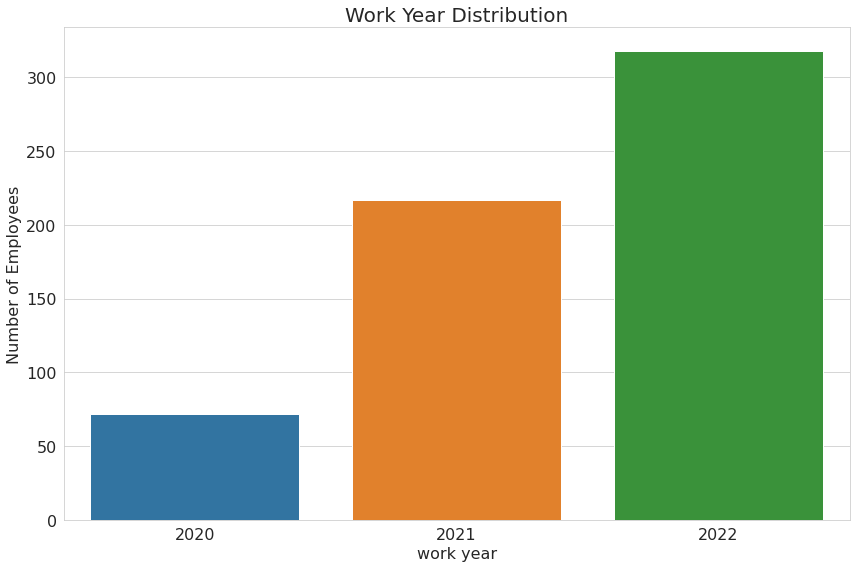

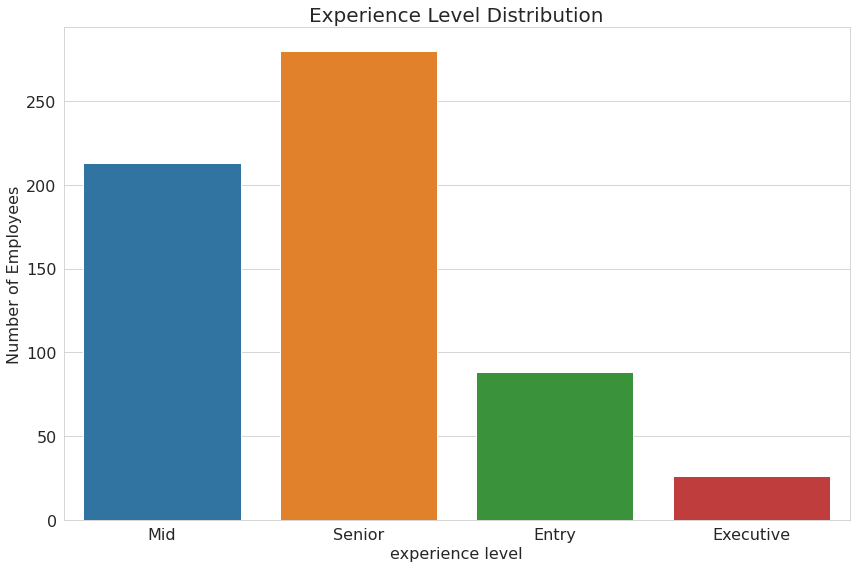

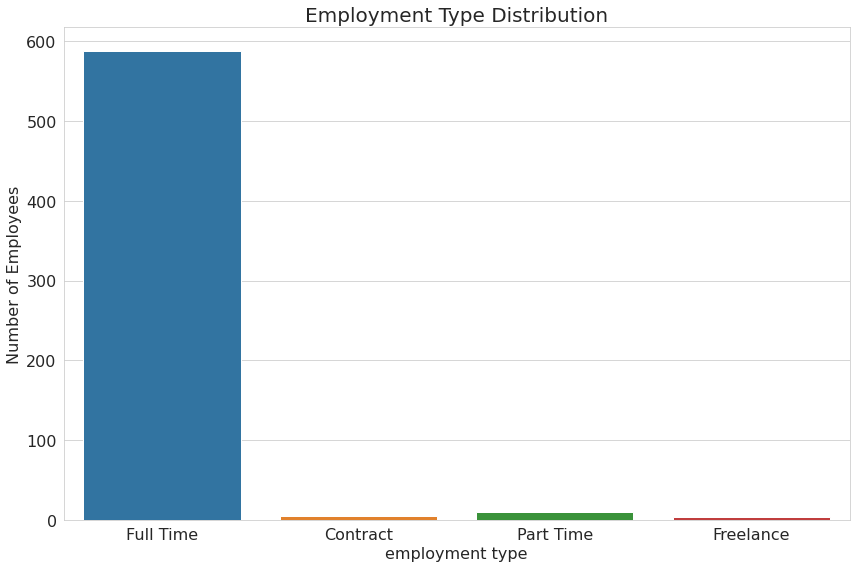

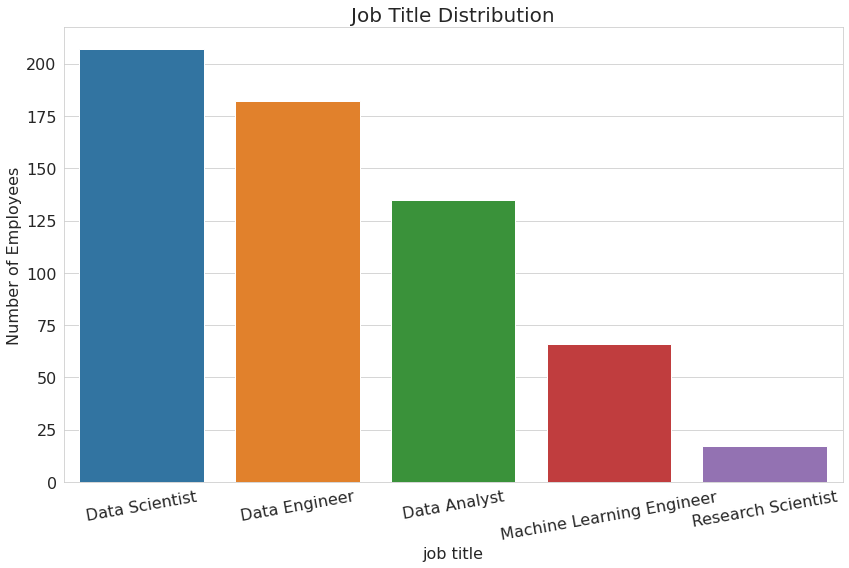

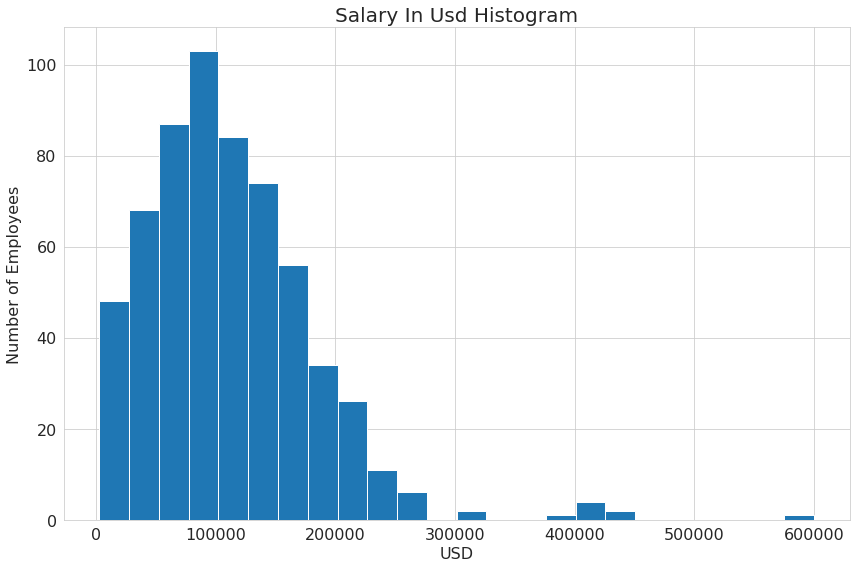

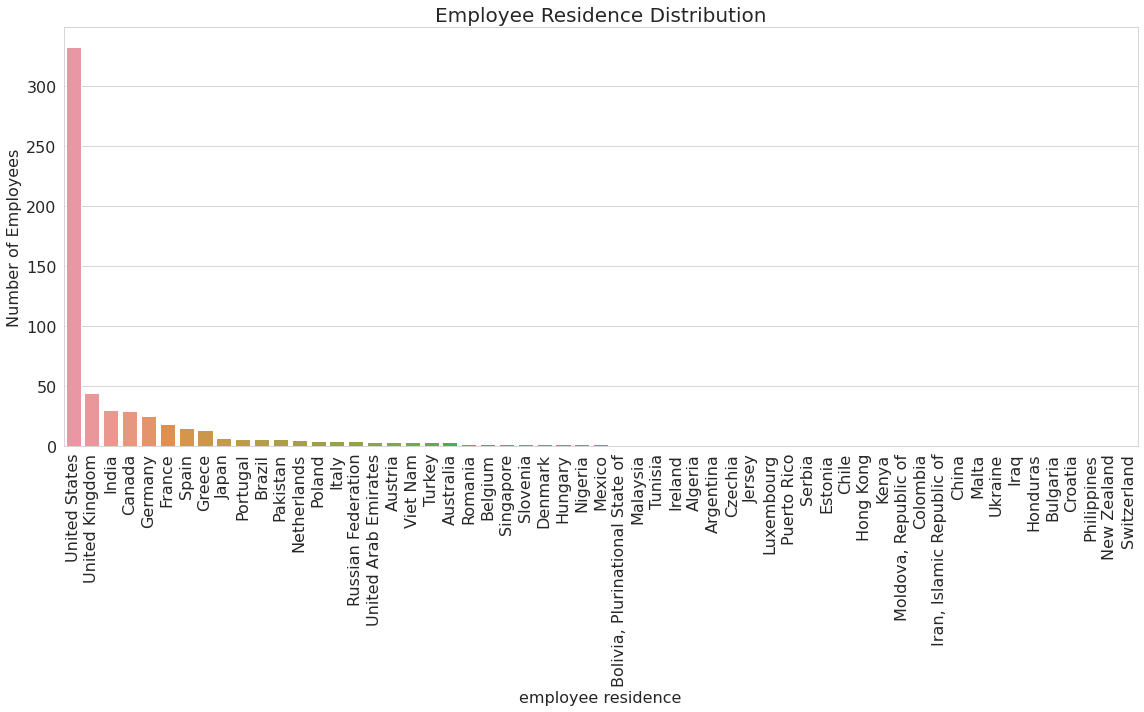

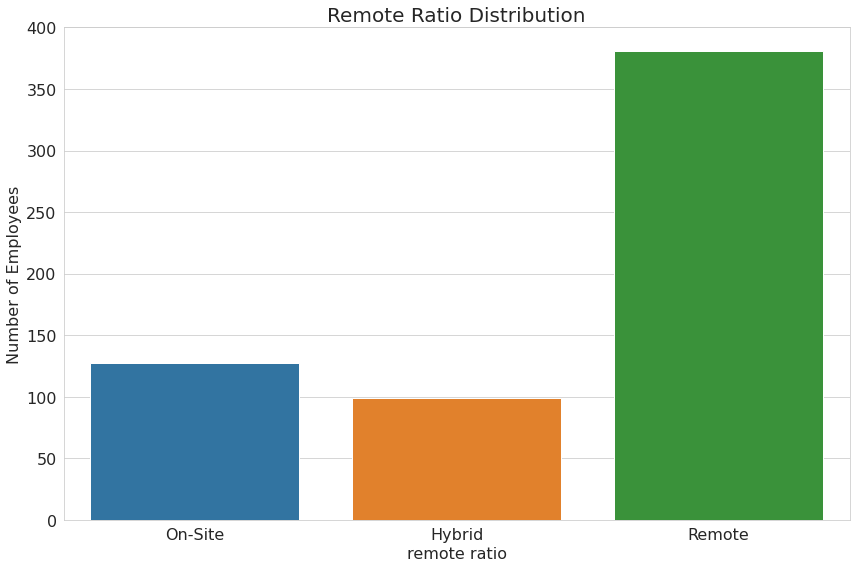

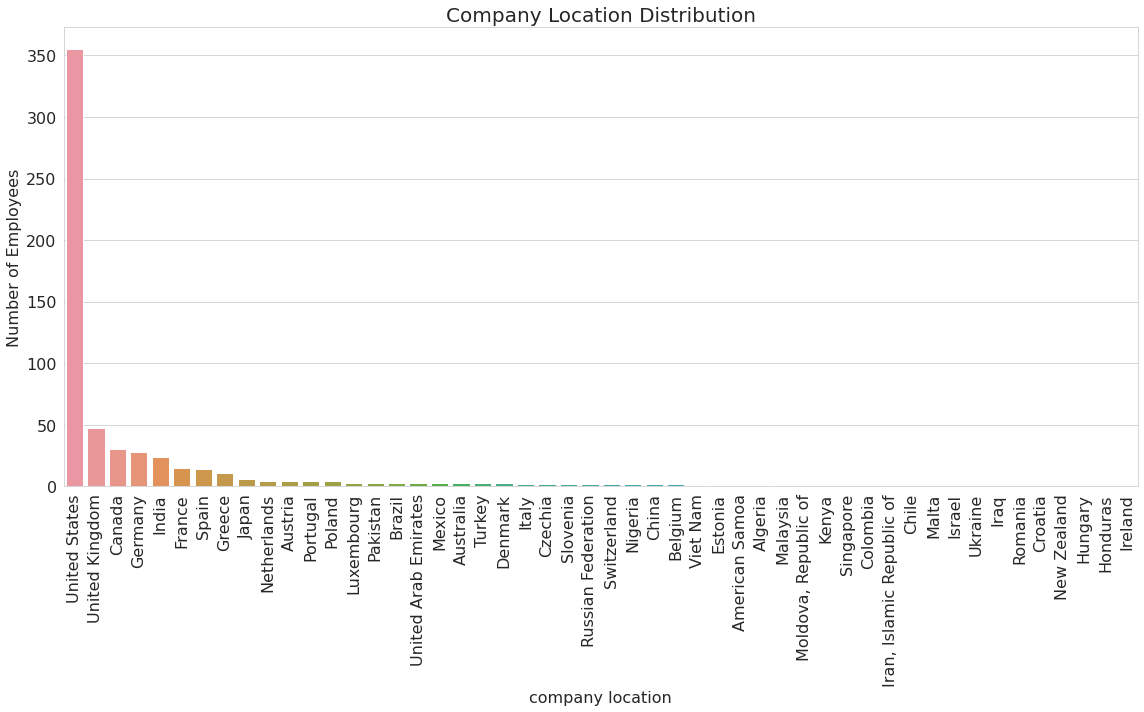

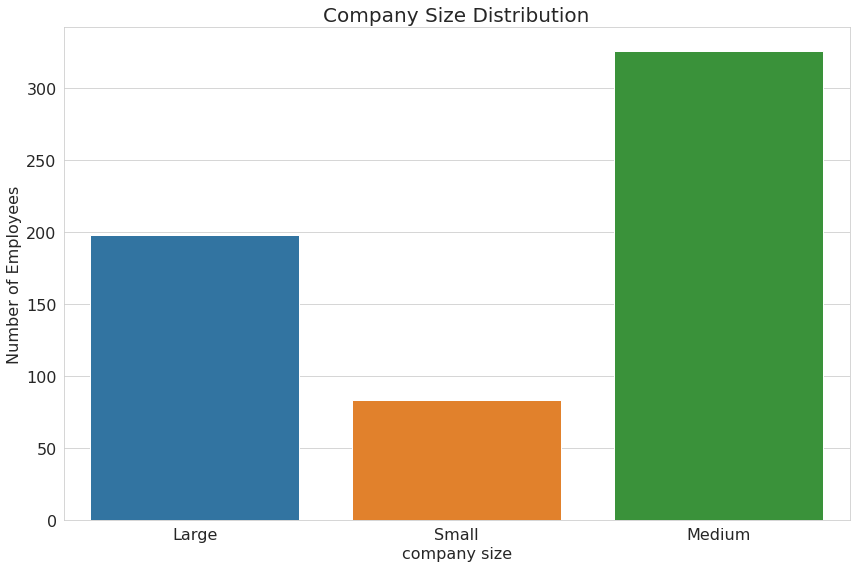

In [9]:
# Plot distributions of all variables in the data
for i, col in enumerate(analysis_data.columns):
    if col == "salary_in_usd":
        plot_salary_histogram(analysis_data, col)
    elif col in analysis_mappers.keys():
        barplot_of_variable(analysis_data, col, mapper=analysis_mappers[col], horizontal=horiz[i])
    else:
        barplot_of_variable(analysis_data, col, horizontal=horiz[i])

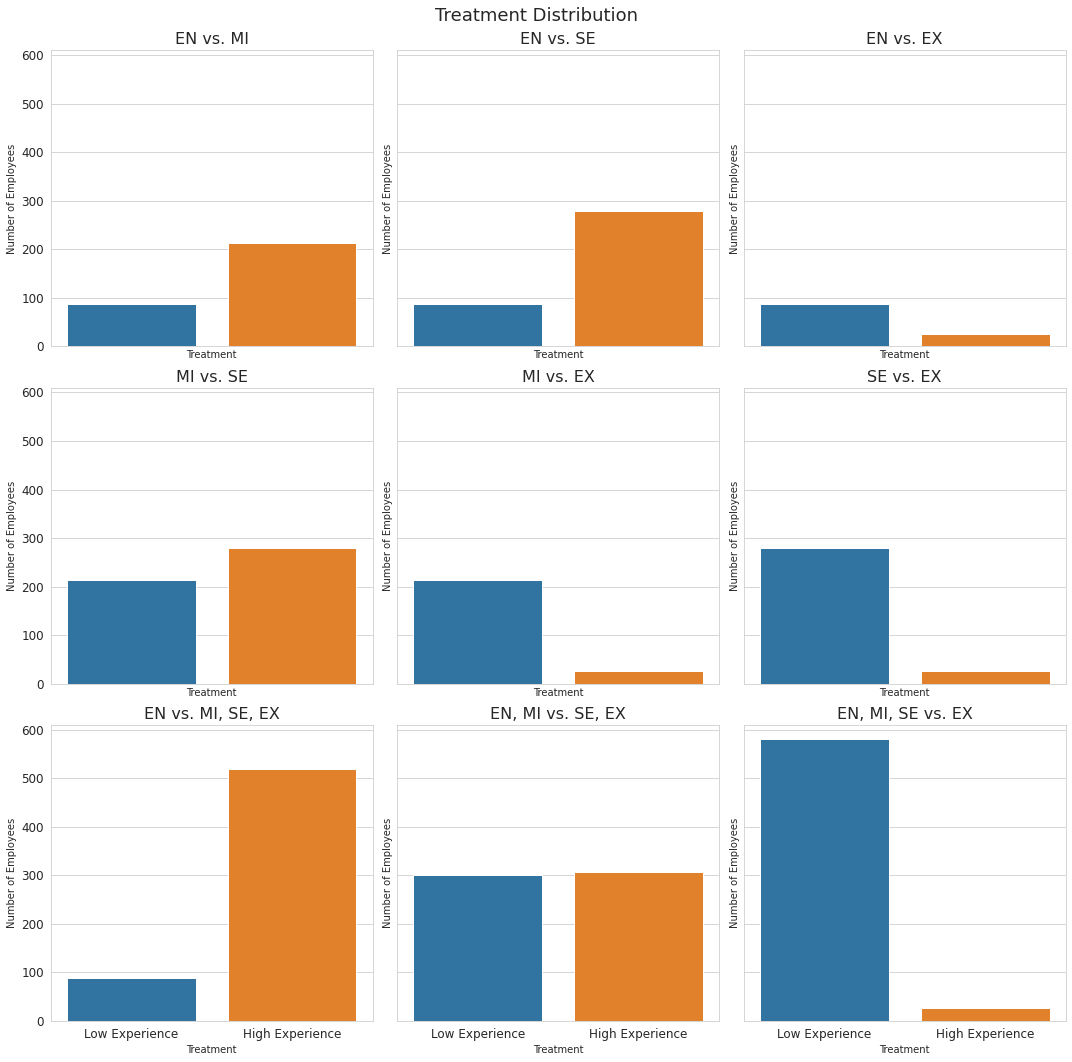

In [10]:
# rename treatment and outcome columns
processed_data = processed_data.rename(columns={"salary_in_usd": "Y"})
processed_data = processed_data.rename(columns={"experience_level": "T"})

fig, ax = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
places = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
# partial sets to for comparison between every two levels
partial_data = {}
place = 0
for i, low in enumerate(LEVELS[:-1]):
    for high in LEVELS[i + 1:]:
        partial = processed_data.copy()
        partial = partial.loc[partial["T"].isin([low, high])]
        partial.loc[partial["T"] == low, "T"] = 0
        partial.loc[partial["T"] == high, "T"] = 1
        for col in COVARIATES_COLS:
            for i, val in enumerate(partial[col].unique()):
                partial.loc[partial[partial[col] == val].index, col] = i
            partial[col] = partial[col].astype(int)
        partial = partial[COVARIATES_COLS + ["T", "Y"]]
        partial_data[f"{low}__{high}"] = partial

        # plot treatment after grouping
        x = [partial[partial["T"] == 0].shape[0], partial[partial["T"] == 1].shape[0]]
        df = pd.DataFrame({"Treatment": ["Low Experience", "High Experience"], "Number of Employees": x})
        sns.barplot(data=df, x="Treatment", y="Number of Employees", ax=ax[places[place]])
        ax[places[place]].set_title(f"{low} vs. {high}", fontsize=16)
        ax[places[place]].tick_params(axis='both', which='major', labelsize=12)
        place += 1


# group the the treatment into 2 levels: LOW and HIGH
for i in range(len(LOW_LEVEL)):
    processed_data[f"T{i}"] = 0
    # processed_data.loc[processed_data[processed_data["T"].isin(LOW_LEVEL[i])].index, f"T{i}"] = 0
    processed_data.loc[processed_data[processed_data["T"].isin(HIGH_LEVEL[i])].index, f"T{i}"] = 1

    # plot treatment after grouping
    x = [processed_data[processed_data[f"T{i}"] == 0].shape[0], processed_data[processed_data[f"T{i}"] == 1].shape[0]]
    df = pd.DataFrame({"Treatment": ["Low Experience", "High Experience"], "Number of Employees": x})
    sns.barplot(data=df, x="Treatment", y="Number of Employees", ax=ax[2, i])
    ax[2, i].set_title(f"{', '.join(LOW_LEVEL[i])} vs. {', '.join(HIGH_LEVEL[i])}", fontsize=16)
    ax[2, i].tick_params(axis='both', which='major', labelsize=12)
    

fig.suptitle("Treatment Distribution", fontsize=18)
fig.tight_layout()
plt.subplots_adjust(top=0.94)
plt.savefig(os.path.join(FIGURES_PATH, f"treatment_distribution.png"))
plt.show()

In [11]:
# Convert all the string columns to numeric values
# Create a mapper that will map each numeric value to the real value
mapper = {}
for col in COVARIATES_COLS:
    mapper[col] = {}
    for i, val in enumerate(processed_data[col].unique()):
        processed_data.loc[processed_data[processed_data[col] == val].index, col] = i
        if col in analysis_mappers.keys():
            mapper[col][i] = analysis_mappers[col][val]
        else:
            mapper[col][i] = val
    processed_data[col] = processed_data[col].astype(int)

# Change the columns order
processed_data = processed_data[COVARIATES_COLS + ["T0", "T1", "T2", "Y"]]

# Data after pre-processing
processed_data

,work_year,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,T0,T1,T2,Y
0,0,0,0,0,0,0,0,1,0,0,79833
1,0,0,0,1,0,1,1,1,1,0,260000
2,0,0,1,2,1,2,2,1,1,0,109024
3,0,0,2,3,0,3,1,1,0,0,20000
4,0,0,3,4,1,4,0,1,1,0,150000
...,...,...,...,...,...,...,...,...,...,...,...
602,2,0,1,4,2,4,2,1,1,0,154000
603,2,0,1,4,2,4,2,1,1,0,126000
604,2,0,2,4,0,4,2,1,1,0,129000
605,2,0,2,4,2,4,2,1,1,0,150000


## Inference and Results

In [12]:
# Functions
def trim_common_support(data: pd.DataFrame, label_name: str) -> pd.DataFrame:
    """
    Removes observations that fall outside the common support of the propensity score distribution from the data.
    
    Arguments:
        data:        DataFrame with the propensity scores for each observation.
        label_name:  Column name that contains the labels (treatment/control) for each observation.
    
    Returns:
        trimmed data
    """
    group_min_max = (data.groupby(label_name).propensity.agg(min_propensity=np.min, max_propensity=np.max))

    # Compute boundaries of common support between the two propensity score distributions
    min_common_support = np.max(group_min_max.min_propensity)
    max_common_support = np.min(group_min_max.max_propensity)

    common_support = (data.propensity >= min_common_support) & (data.propensity <= max_common_support)
    control = (data[label_name] == 0)
    treated = (data[label_name] == 1)
    
    return data[common_support]


def match_tc(group: int, label: pd.Series, propensity: pd.Series, calipher: float = 0.05, replace: bool = True) -> Dict[int, List[int]]:
    """
    Performs nearest-neighbour matching for a sample of test and control observations, based on the propensity scores for each observation.

    Arguments:
        group:      The label group to match to. 1 for treated, 0 for control.
        label:      Series that contains the label for each observation.
        propensity: Series that contains the propensity score for each observation.
        calipher:   Bound on distance between observations in terms of propensity score.
        replace:    Boolean that indicates whether sampling is with (True) or without replacement (False).
    
    Returns:
        matches
    """
    if group not in [0, 1]:
        raise ValueError(f"group can receive only values in {0, 1}. Got group={group}.")
    
    matched = propensity[label == group]
    other = propensity[label == 1 - group]

    # Randomly permute in case of sampling without replacement to remove any bias arising from the ordering of the data set
    matching_order = np.random.permutation(label[label == group].index)
    matches = {}

    for obs in matching_order:
        # Compute the distance between the treatment observation and all candidate controls in terms of propensity score
        distance = abs(matched[obs] - other)

        # Take the closest match
        if distance.min() <= calipher or not calipher:
            matches[obs] = [distance.idxmin()]
            
            # Remove the matched control from the set of candidate controls in case of sampling without replacement
            if not replace:
                other = other.drop(matches[obs])
    
    return matches


def matching(label: pd.Series, propensity: pd.Series, calipher: float = 0.05,
             replace: bool = True) -> Tuple[Dict[int, List[int]], Dict[int, List[int]]]:
    """
    Performs nearest-neighbour matching for a sample of test and control observations, based on the propensity scores for each observation.

    Arguments:
        label:      Series that contains the label for each observation.
        propensity: Series that contains the propensity score for each observation.
        calipher:   Bound on distance between observations in terms of propensity score.
        replace:    Boolean that indicates whether sampling is with (True) or without replacement (False).
    
    Returns:
        matches with respect to treated and control groups.
    """
    matches_t = match_tc(1, label, propensity, calipher, replace)  # matches with respect to treated group
    matches_c = match_tc(0, label, propensity, calipher, replace)  # matches with respect to control group
    return matches_t, matches_c


def matching_to_dataframe(match: Dict[int, List[int]], covariates: pd.DataFrame, remove_duplicates: bool = False) -> pd.DataFrame:
    """
    Converts a list of matches obtained from matching() to a DataFrame. Duplicate rows are controls that where matched multiple times.

    Arguments:
        match:              Dictionary with a list of matched control observations.
        covariates:         DataFrame that contains the covariates for the observations.
        remove_duplicates:  Boolean that indicates whether or not to remove duplicate rows from the result. 
                            If matching with replacement was used you should set this to False****
    
    Returns:
        data frame of matches
    """
    treated = list(match.keys())
    control = [ctrl for matched_list in match.values() for ctrl in matched_list]

    result = pd.concat([covariates.loc[treated], covariates.loc[control]])

    if remove_duplicates:
        return result.groupby(result.index).first()
    else:
        return result
    

def plot_var(before_match: pd.DataFrame, after_match: pd.DataFrame, treat_scheme: str, var_name: str, val_range: Tuple[float, float],
             plot_kind: str, propensity_method: str, mapper: Dict[int, str], exp_name: str):
    """
    Plots a single variable before and after matching.

    Arguments:
        before_match:       Data before matching.
        after_match:        Data after matching.
        treat_scheme:       The treatment scheme used for the inference.
        var_name:           Name of the variable to plot.
        val_range:          Range of the possible values for the variable.
        plot_kind:          "hist" for histogram or "bar" for barplot.
        propensity_method:  "lin" for using all linear covariates, "imbens" for using Imbens algorithm for propensity estimation,
                            including quadratic covariates.
        mapper:             Mapper between the numeric value and the real value.
        exp_name:           Name of current experiment.
    
    Returns:
        None
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharex=True, sharey=True)
    if plot_kind == "hist":
        before_match.groupby(treat_scheme)[var_name].plot(kind=plot_kind, range=val_range, bins=20, alpha = 0.75, ax=ax1)
        after_match.groupby(treat_scheme)[var_name].plot(kind=plot_kind, range=val_range, bins=20, alpha = 0.75, ax=ax2)
        xtick_labels = list(before_match[var_name].unique())
    elif plot_kind == "bar":
        tmp1 = before_match.groupby([treat_scheme, var_name])[var_name].count().unstack(level=treat_scheme)
        for i in range(tmp1.index.max() + 1):
            if i not in tmp1.index:
                tmp1.loc[i] = 0
        tmp1.sort_index().plot(kind=plot_kind, sharex=True, alpha = 0.75, ax=ax1)
        tmp2 = after_match.groupby([treat_scheme, var_name])[var_name].count().unstack(level=treat_scheme)
        for i in range(tmp2.index.max() + 1):
            if i not in tmp2.index:
                tmp2.loc[i] = 0
        tmp2.sort_index().plot(kind=plot_kind, sharex=True, alpha = 0.75, ax=ax2)
        xtick_labels = list(tmp1.index)  

    else:
        raise NotImplementedError(f"plot_kind should be 'hist' or 'bar'. Got plot_kind={plot_kind}")
    
    label = var_name.replace("_", " ")
    title = label.title()

    if var_name in mapper.keys():
        angle = 90 if len(mapper[var_name].values()) > 10 else 0
        if var_name == 'job_title':
            angle = 10
        l = [mapper[var_name][i] for i in xtick_labels]
        ax1.set_xticks(xtick_labels)
        ax2.set_xticks(xtick_labels)
        ax1.set_xticklabels(labels=l, rotation=angle)
        ax2.set_xticklabels(labels=l, rotation=angle)

    ax1.set_title(f"Before Matching", fontsize=16)
    ax1.set_xlabel(label, fontsize=14)
    ax1.set_ylabel("number of employees", fontsize=14)
    ax1.legend(title="Treatment")
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax2.set_title(f"After Matching", fontsize=16)
    ax2.set_xlabel(label, fontsize=14)
    ax2.set_ylabel("number of employees", fontsize=14)
    ax2.legend(title="Treatment")
    ax2.tick_params(axis='both', which='major', labelsize=12)
    
    low, high = exp_name.split('__')
    fig.suptitle(f"{title} - {', '.join(low.split('_'))} vs. {', '.join(high.split('_'))}", fontsize=18)
    fig.tight_layout()
    plt.subplots_adjust(top=0.88)

    plt.savefig(os.path.join(FIGURES_PATH, f"{var_name}_matching_{propensity_method}_{exp_name}.png"))
    plt.show()


def calculate_conf_interval(samples: List[float], stat_name: str, results: Dict[str, float], alpha: float):
    """
    Calculates the mean, std and confidence values of a certain stat.

    Arguments:
        samples:    Values for all samples.
        stat_name:  Name of the stat to calculate.
        results:    Dictionary of results for all stats.
        alpha:      Significance level.
    
    Returns:
        None
    """
    n = len(samples)  # number of samples
    results[stat_name] = np.mean(samples)  # mean value
    results[f"{stat_name}_std"] = np.std(samples)  # standard deviation
    lower = results[stat_name] - ss.norm.ppf(1 - alpha / 2) * results[f"{stat_name}_std"] / np.sqrt(n)  # lower bound of confidence interval
    upper = results[stat_name] + ss.norm.ppf(1 - alpha / 2) * results[f"{stat_name}_std"] / np.sqrt(n)  # upper bound of confidence interval
    results[f"{stat_name}_conf"] = [round(lower, 1), round(upper, 1)]

In [13]:
# Main function for inference

def infer(df: pd.DataFrame, treat_scheme: str, mapper: Dict[int, str], exp_name: str, propensity_method: str = "lin", alpha: float = 0.05,
          plot: bool = True) -> Dict[str, Union[float, List[float]]]:
    """
    Infers on the data after pre-processing. Estimates the propensity scores, calculates the matches,
    plots results before and after matching, calculates ATT, ATC, and ATE, and their confidence intervals.

    Arguments:
        df:                 The data.
        treat_scheme:       The treatment scheme used for the inference.
        mapper:             Mapper between the numeric value and the real value.
        exp_name:           Name of current experiment.
        propensity_method:  "lin" for using all linear covariates, "imbens" for using Imbens algorithm for propensity estimation,
                            including quadratic covariates.
        alpha:              Significance level.
        plot:               Plots results if True, else doesn't plot.

    Returns:
        Results for all stats.
    """
    df = df.copy()
    
    # creating the Causal Inference model
    cm = CausalModel(Y=df["Y"].values, D=df[treat_scheme].values, X=df[COVARIATES_COLS].values)

    # compute the propensity
    if propensity_method == "lin":
        cm.est_propensity()
    elif propensity_method == "imbens":
        cm.est_propensity_s()
    else:
        raise NotImplementedError(f"Propensity method {propensity_method} is not implemented.")

    # get the covariates
    lin_covariates = list(map(lambda e: df.columns[e], cm.propensity["lin"]))
    quad_covariates = list(map(lambda e: f"{df.columns[e[0]]} * {df.columns[e[1]]}", cm.propensity["qua"]))
    covariates = lin_covariates + quad_covariates

    propensity = cm.propensity["fitted"]
    df["propensity"] = propensity

    # calculate matches
    common_support = trim_common_support(df, treat_scheme)
    matches_t, matches_c = matching(label=common_support[treat_scheme], propensity=common_support["propensity"], calipher=0.0, replace=True)
    matches_t_df = matching_to_dataframe(match=matches_t, covariates=common_support, remove_duplicates=False)
    matches_c_df = matching_to_dataframe(match=matches_c, covariates=common_support, remove_duplicates=False)

    if plot:
        # plot propensities before and after matching
        plot_var(df, matches_t_df, treat_scheme, "propensity", (0, 1), "hist", propensity_method, mapper, exp_name)
        # plot covariates before and after matching
        for cov in COVARIATES_COLS:
            plot_var(df, matches_t_df, treat_scheme, cov, (df[cov].min(), df[cov].max()), "bar", propensity_method, mapper, exp_name)

    itt = [df["Y"][k] - df["Y"][v[0]] for k, v in matches_t.items()]
    itc = [df["Y"][v[0]] - df["Y"][k] for k, v in matches_c.items()]
    ite = itt + itc
    
    results = {}
    # calculate stat estimations and confidence intervals
    for samples, name in zip((itt, itc, ite), ("att", "atc", "ate")):
        calculate_conf_interval(samples, name, results, alpha)

    return results

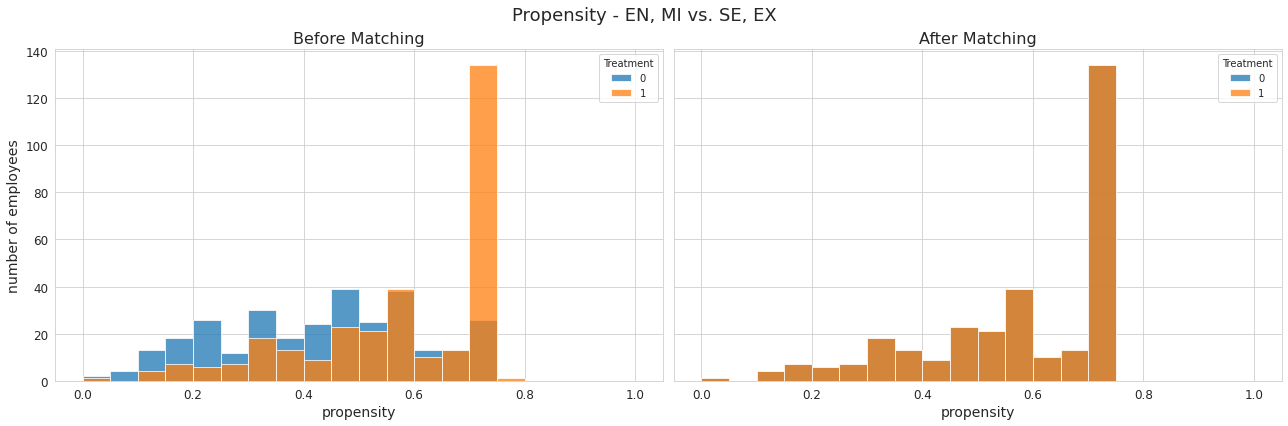

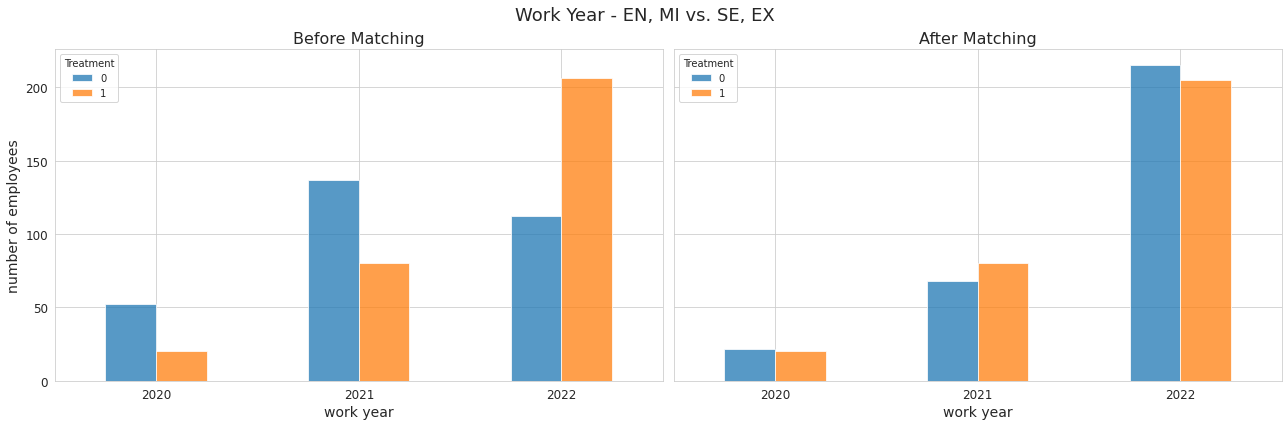

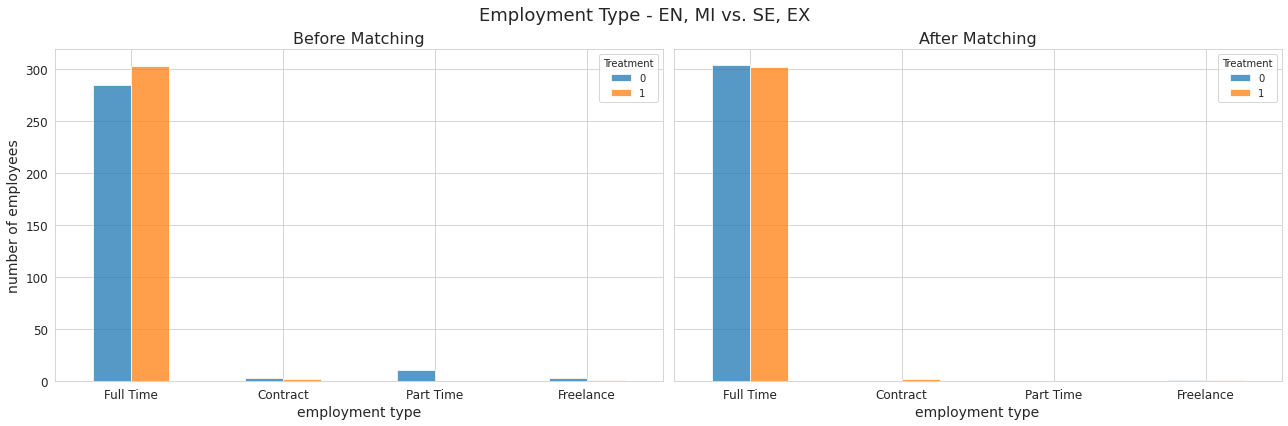

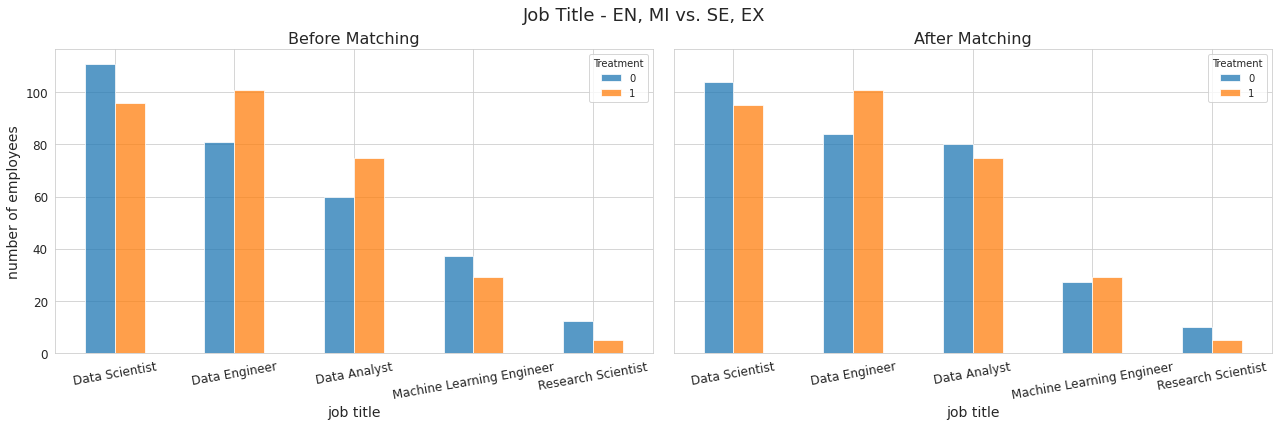

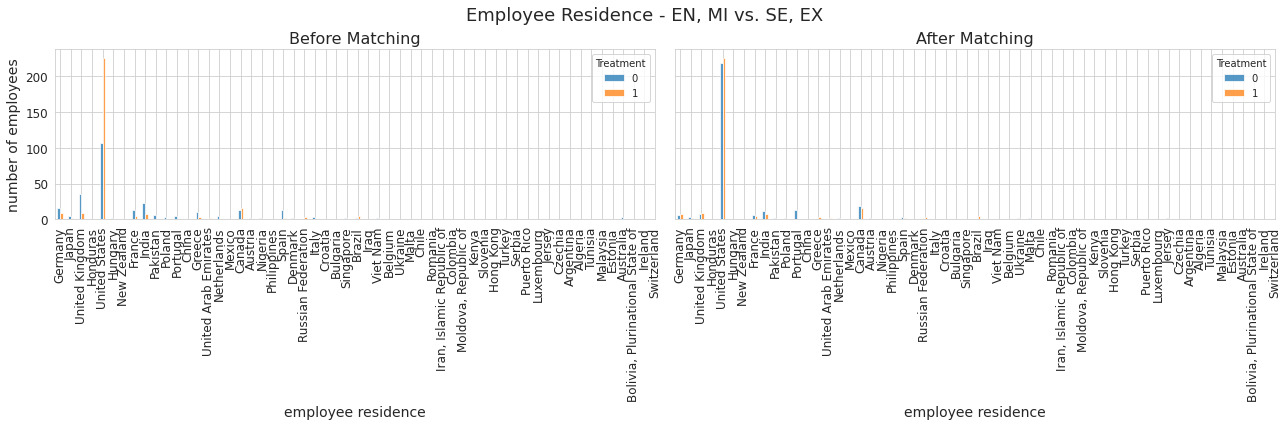

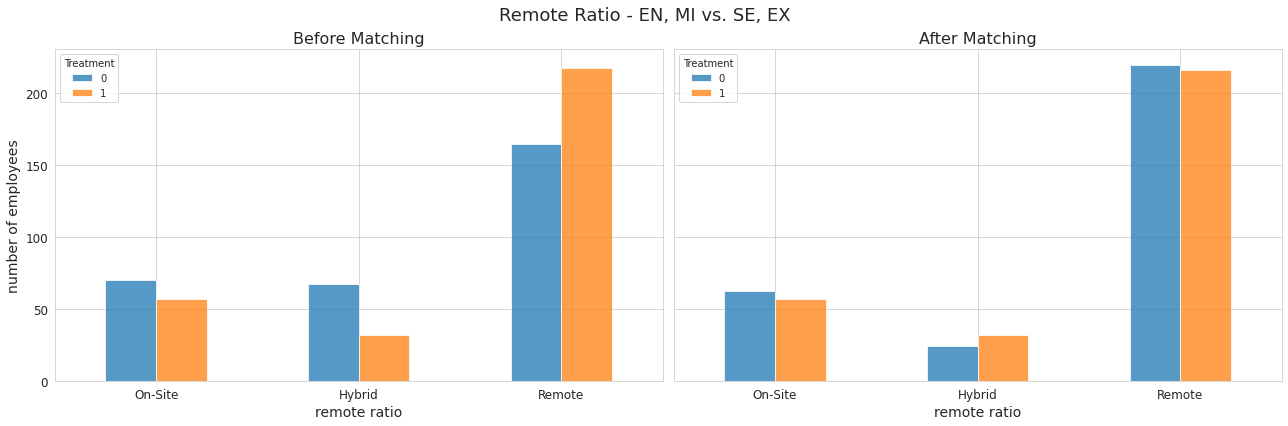

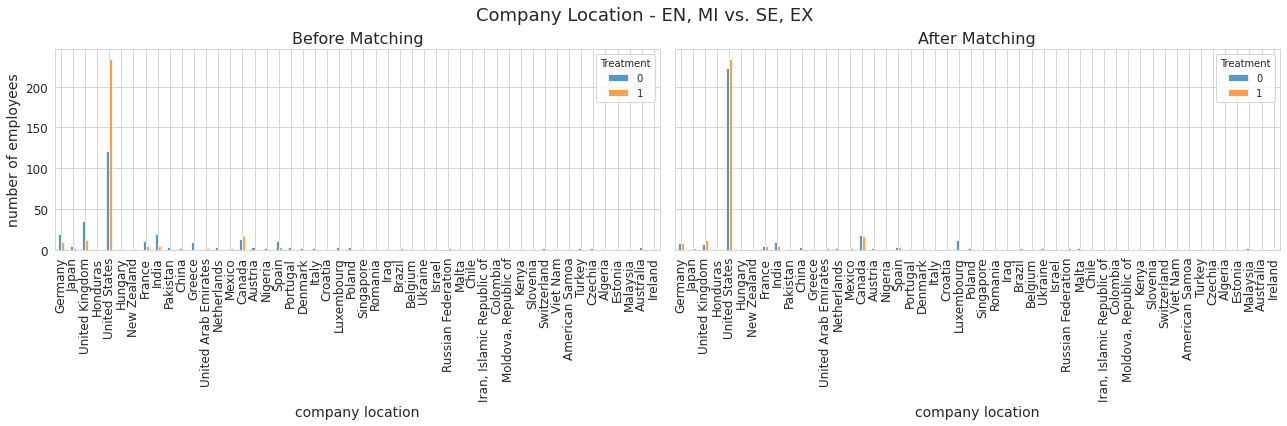

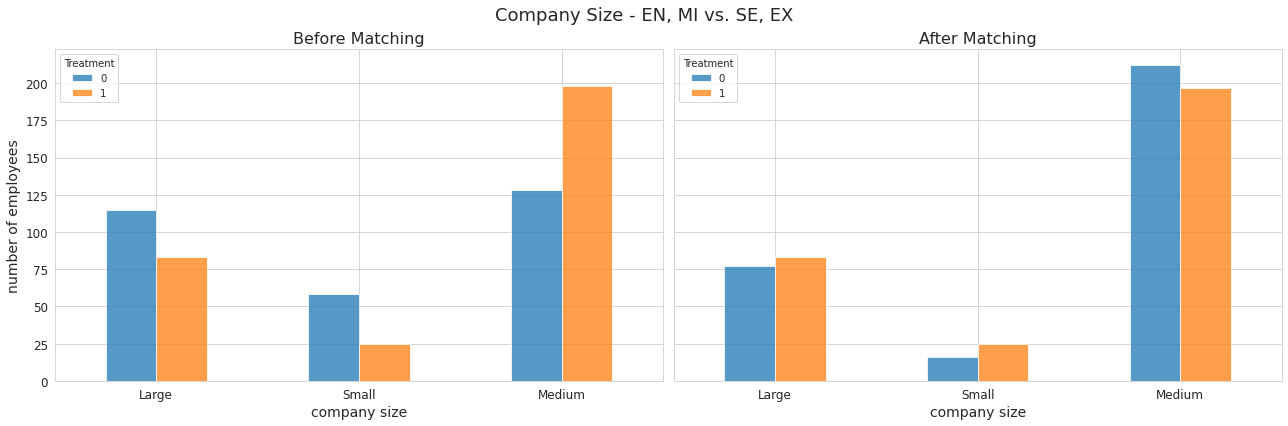

In [14]:
# Infer for propensity estimation using linear covariates - group against group
alpha = 0.05
drop_cols = [["T0", "T1", "T2"], ["T1", "T0", "T2"], ["T2", "T0", "T1"]]
plot = [False, True, False]  # to plot all experiments, change all elements to True

results_lin = {}
for i, cols in enumerate(drop_cols):
    exp_name = f"{'_'.join(LOW_LEVEL[i])}__{'_'.join(HIGH_LEVEL[i])}"
    results_lin[exp_name] = infer(processed_data.drop(columns=cols[1:]), treat_scheme=cols[0], propensity_method="lin", alpha=alpha,
                             plot=plot[i], mapper=mapper, exp_name=exp_name)

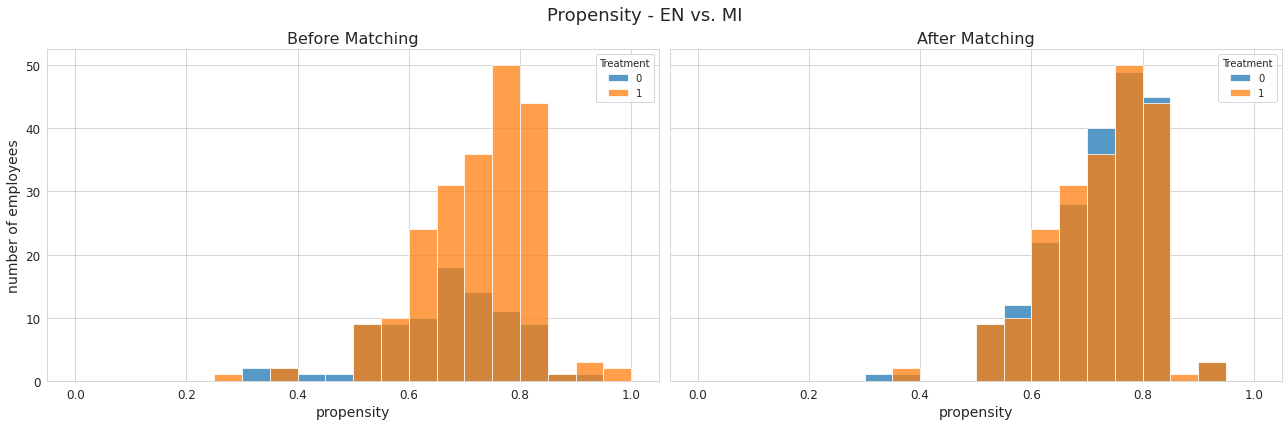

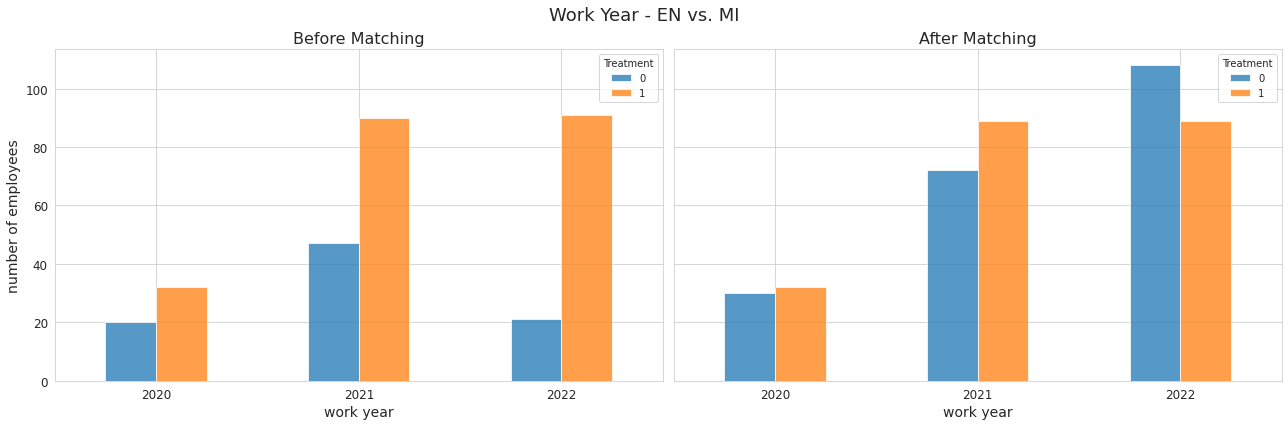

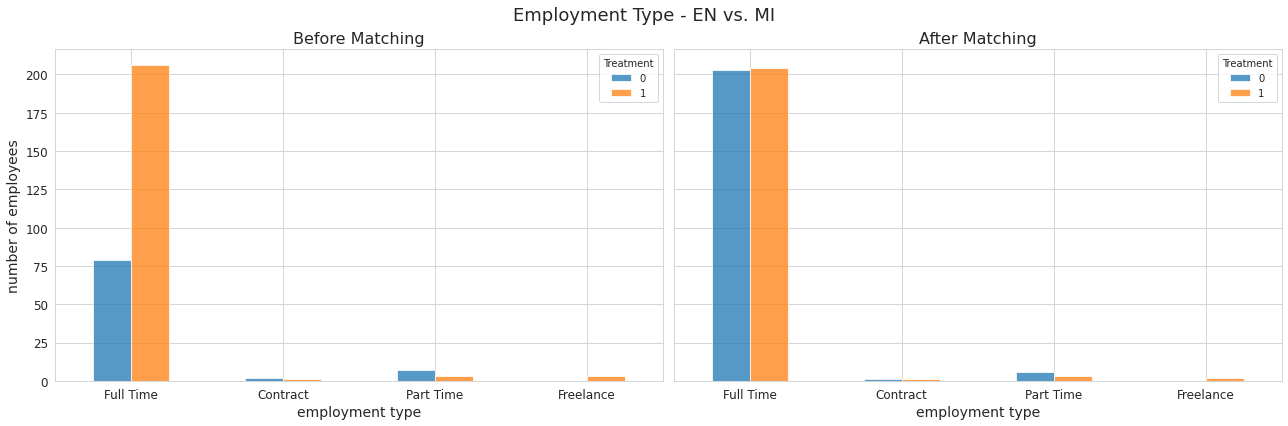

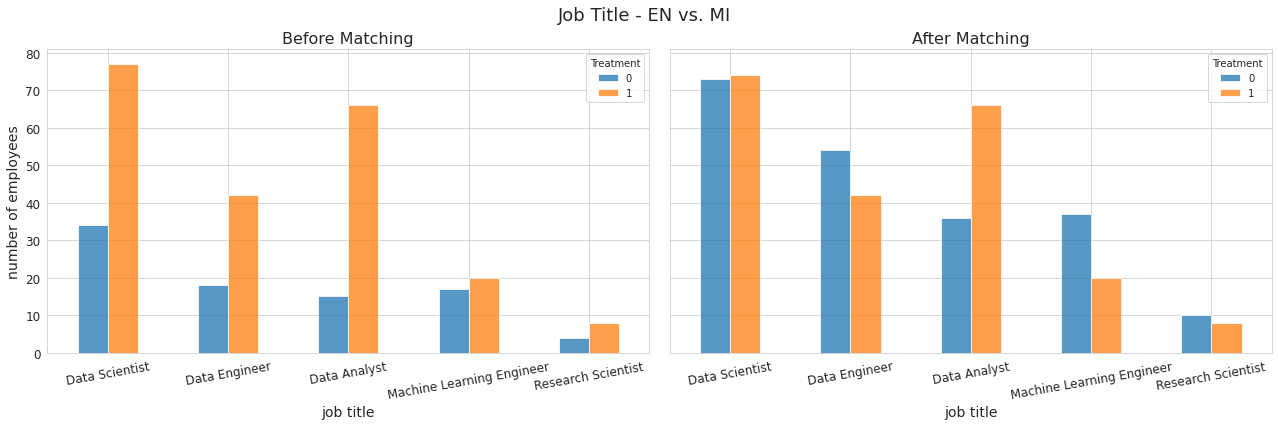

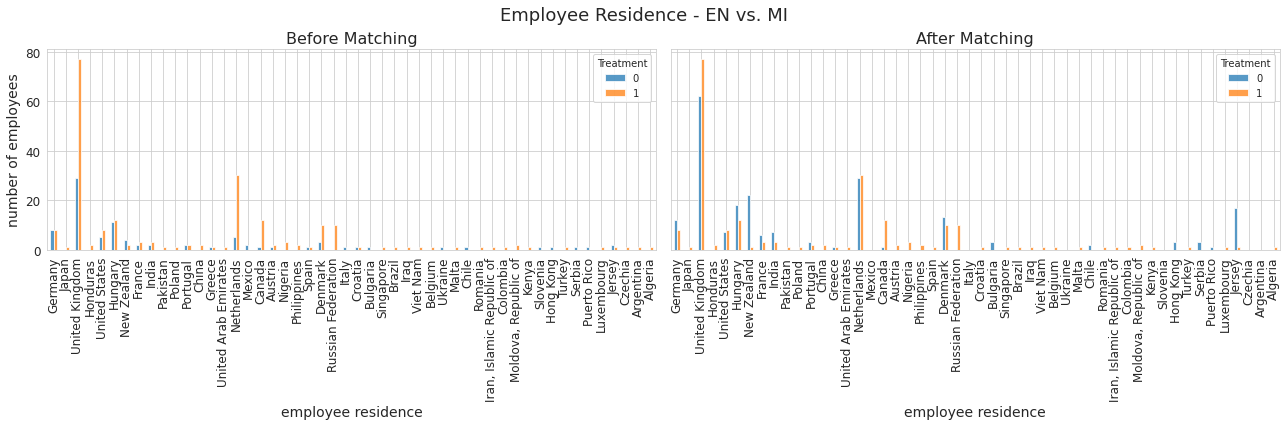

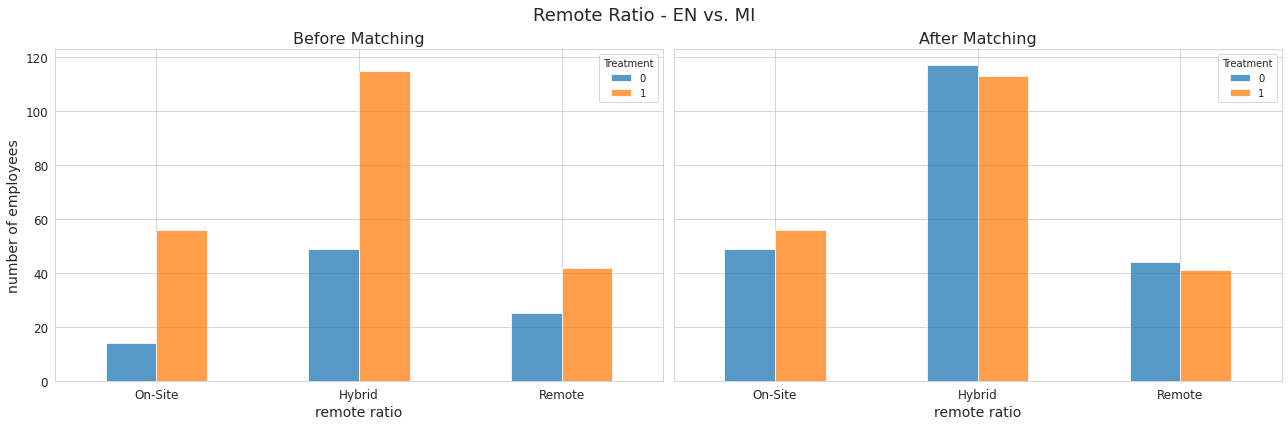

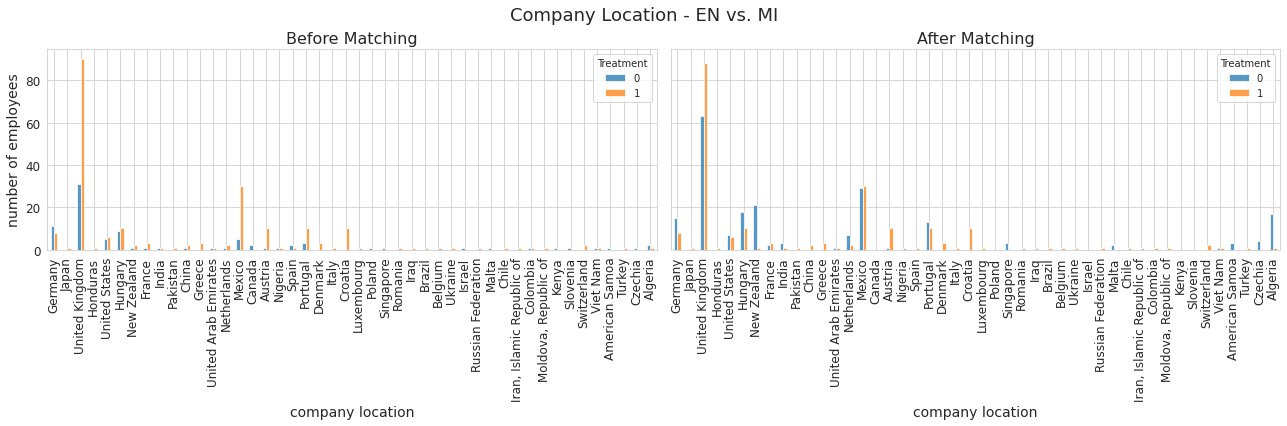

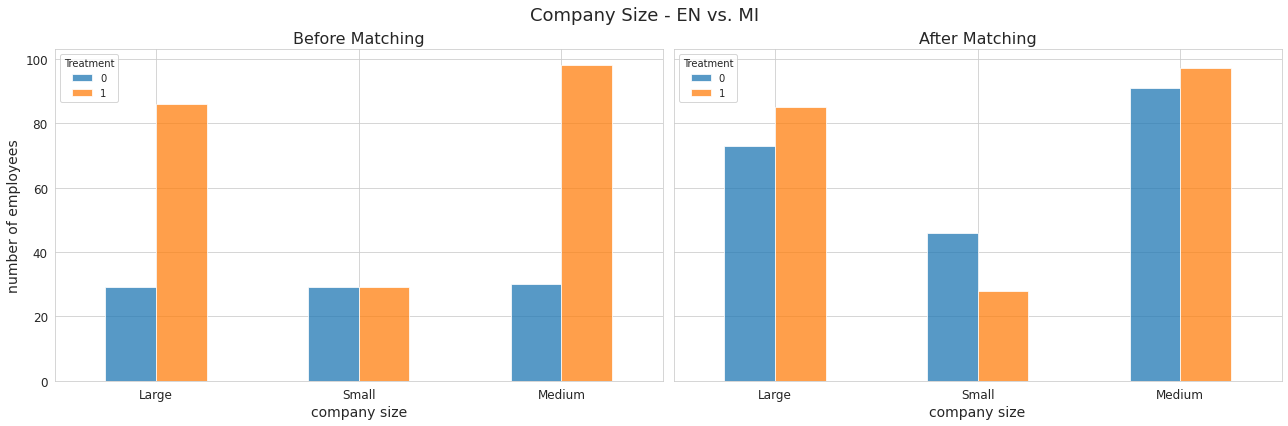

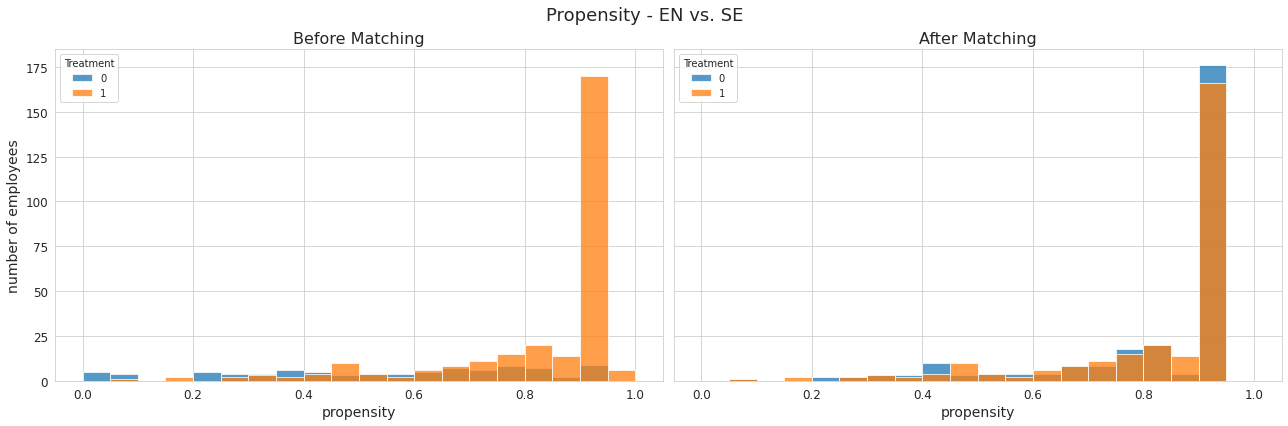

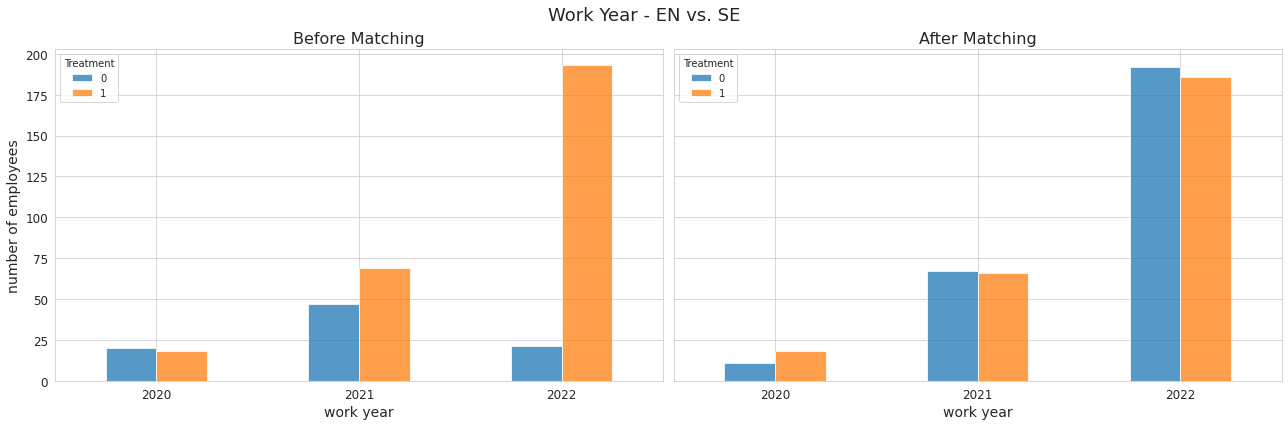

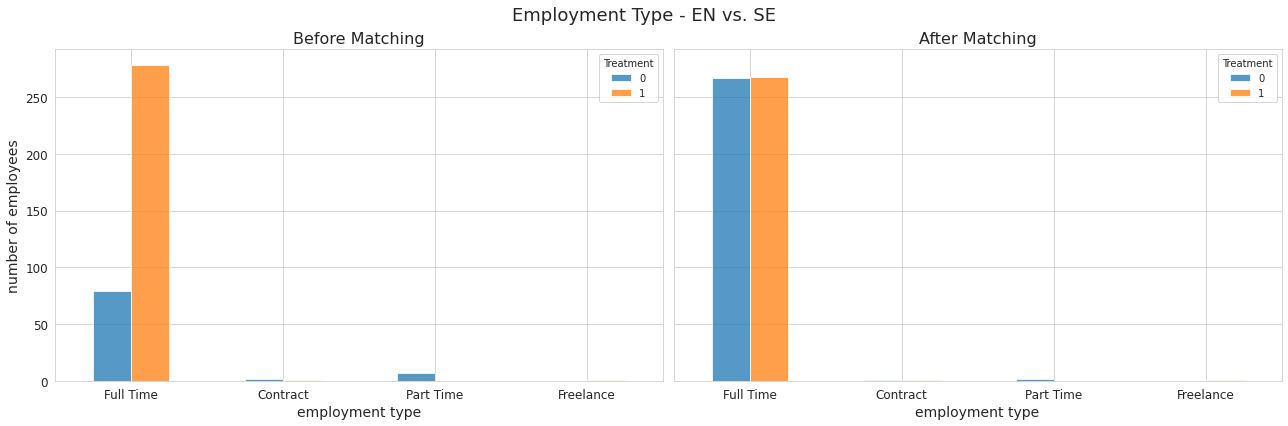

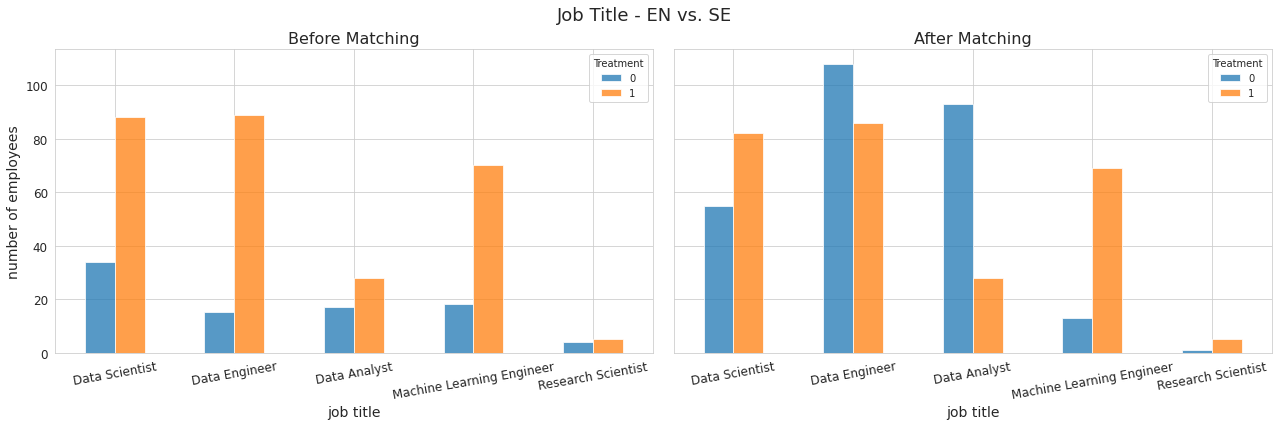

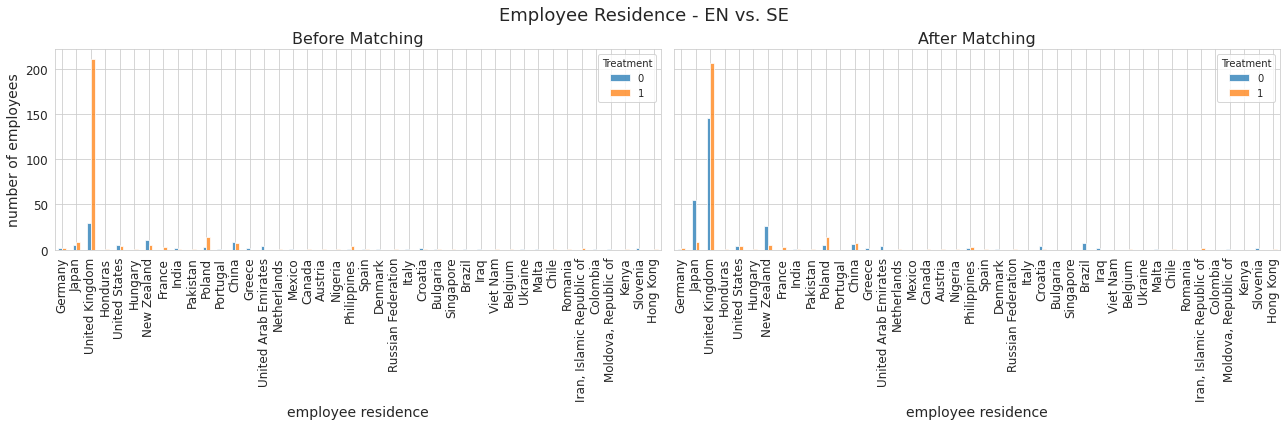

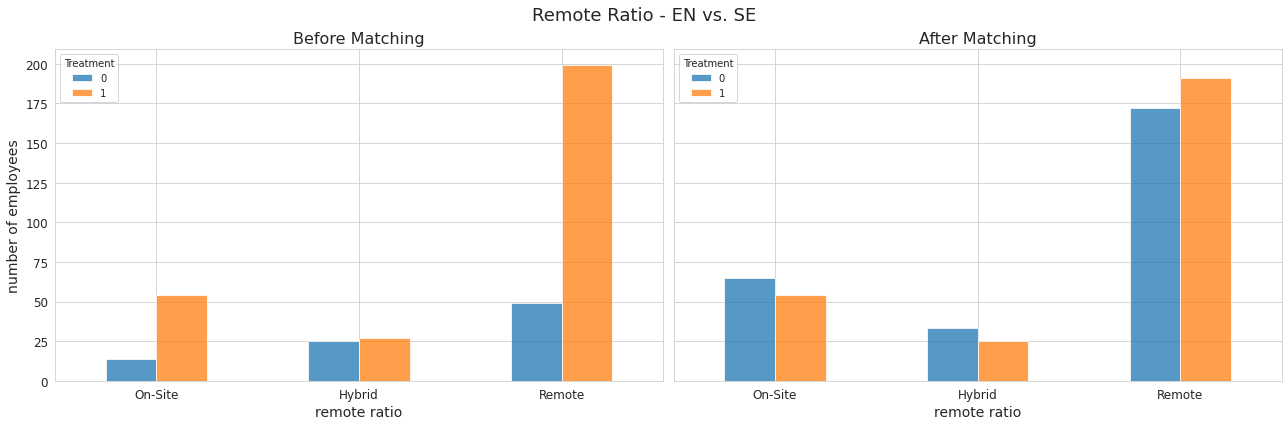

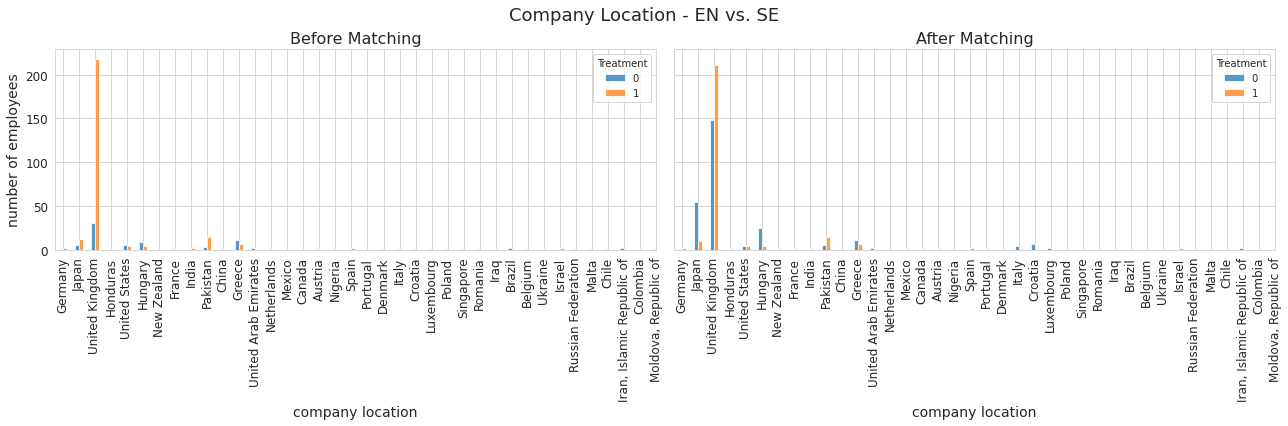

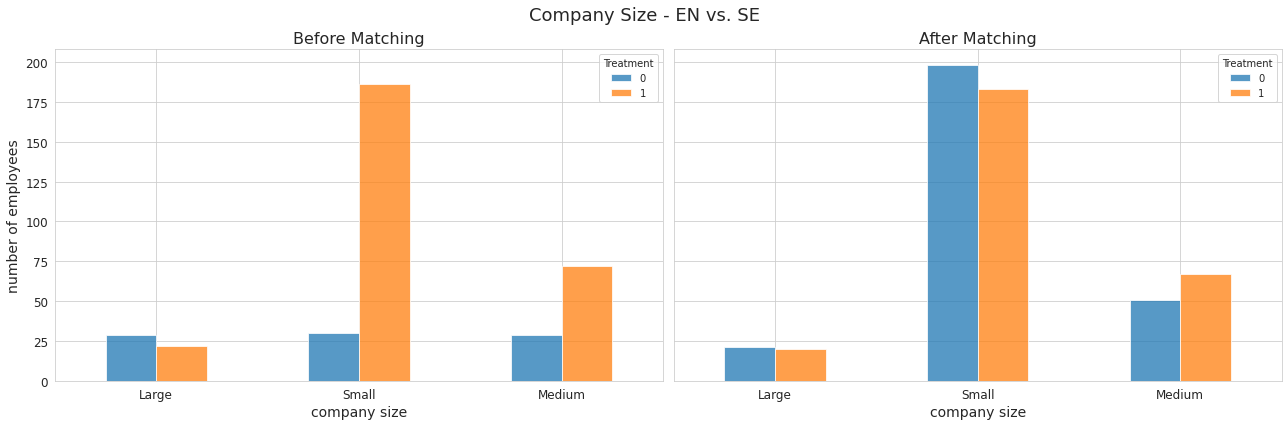

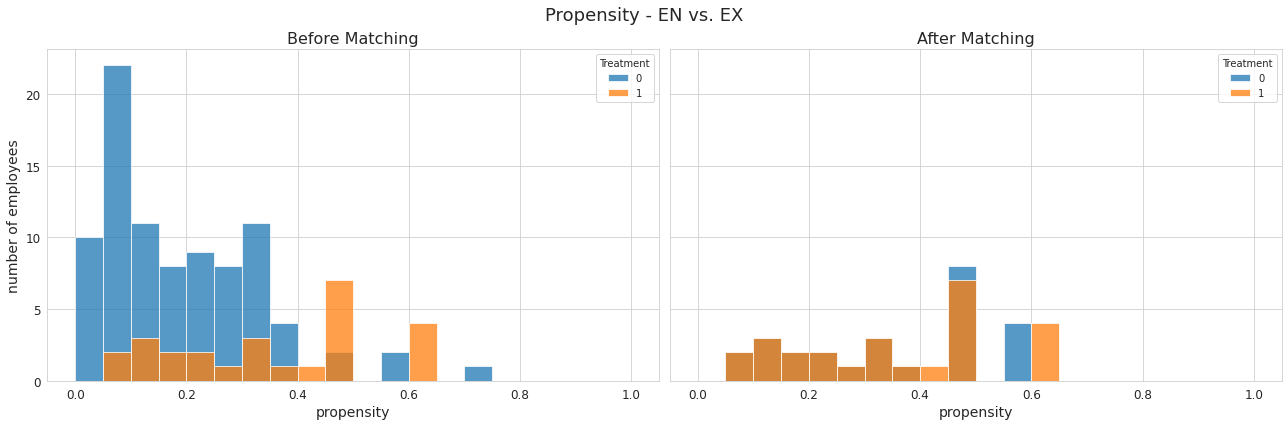

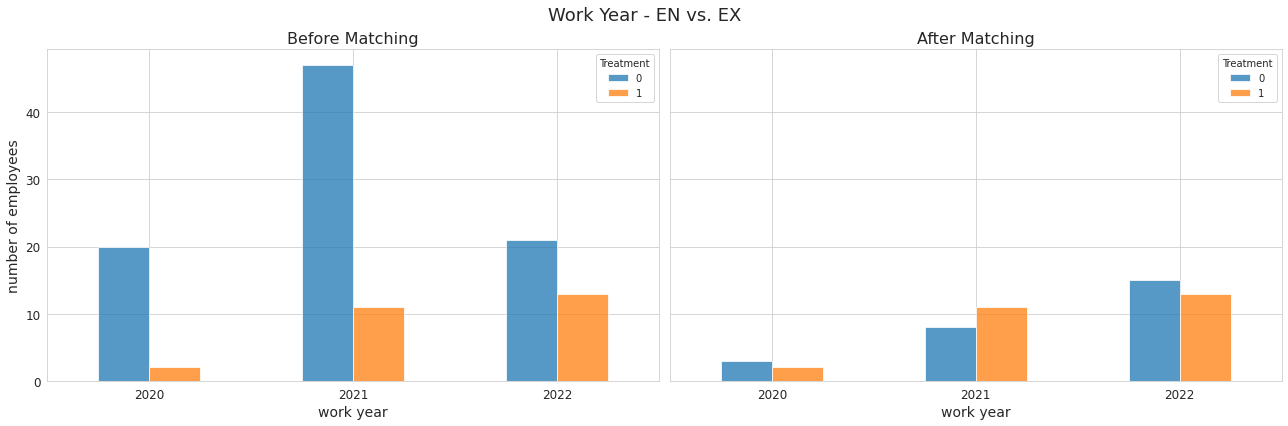

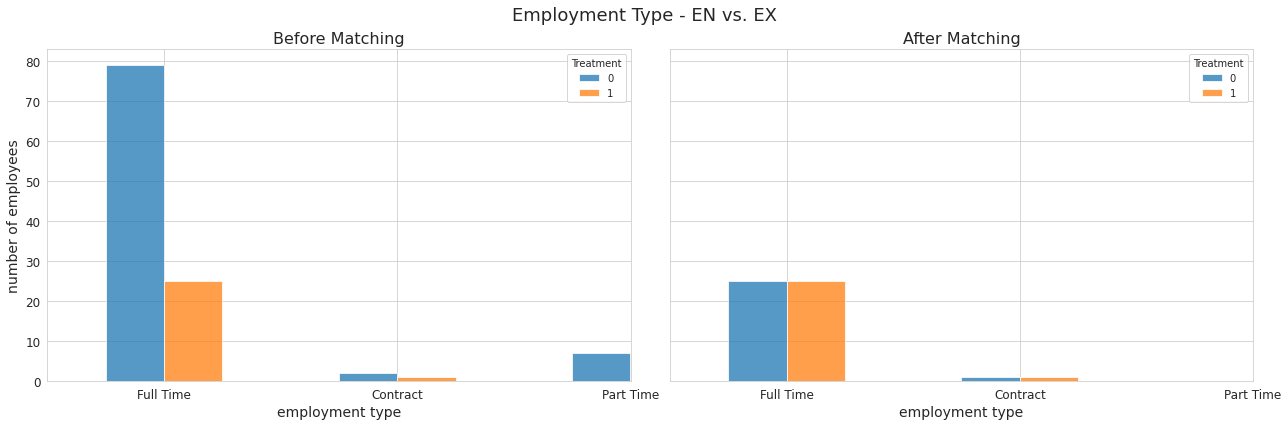

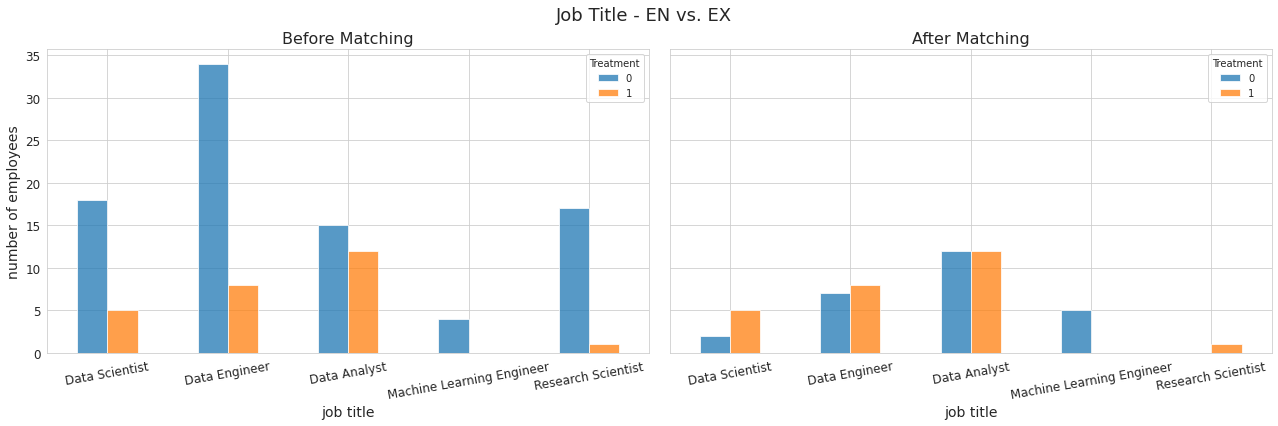

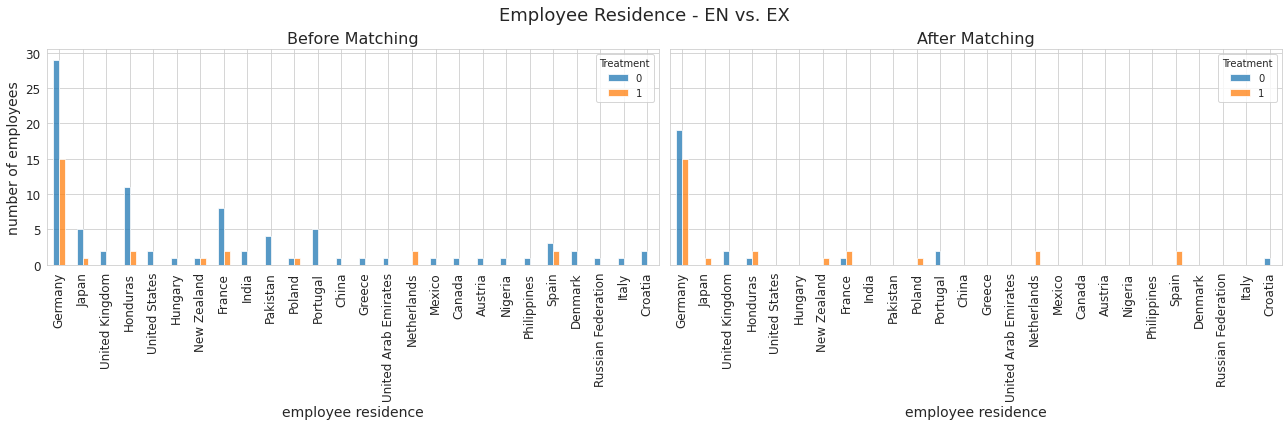

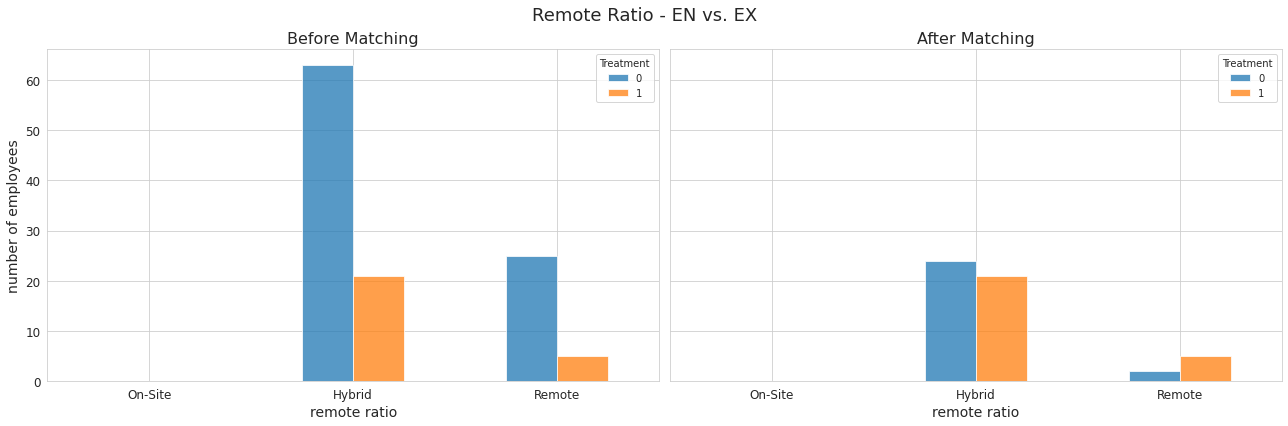

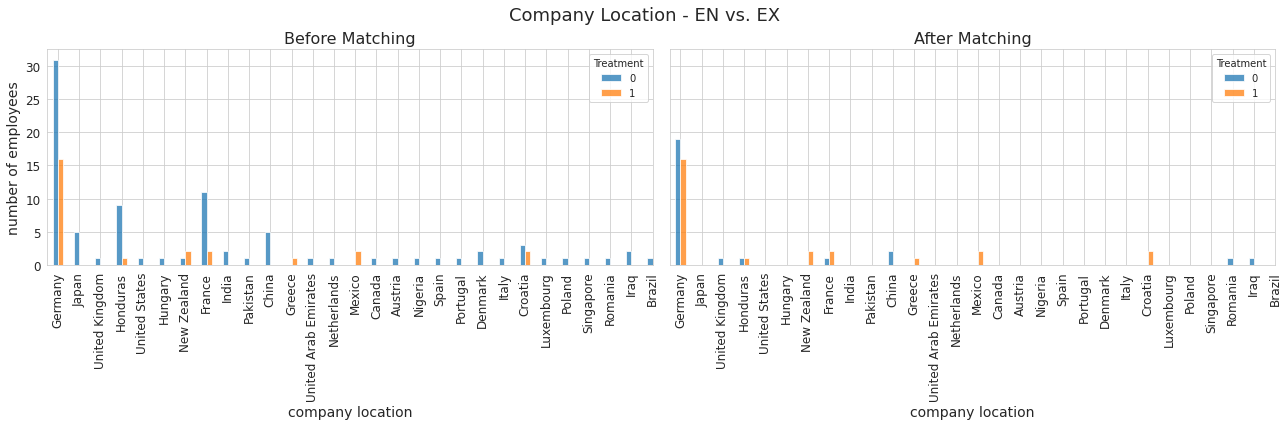

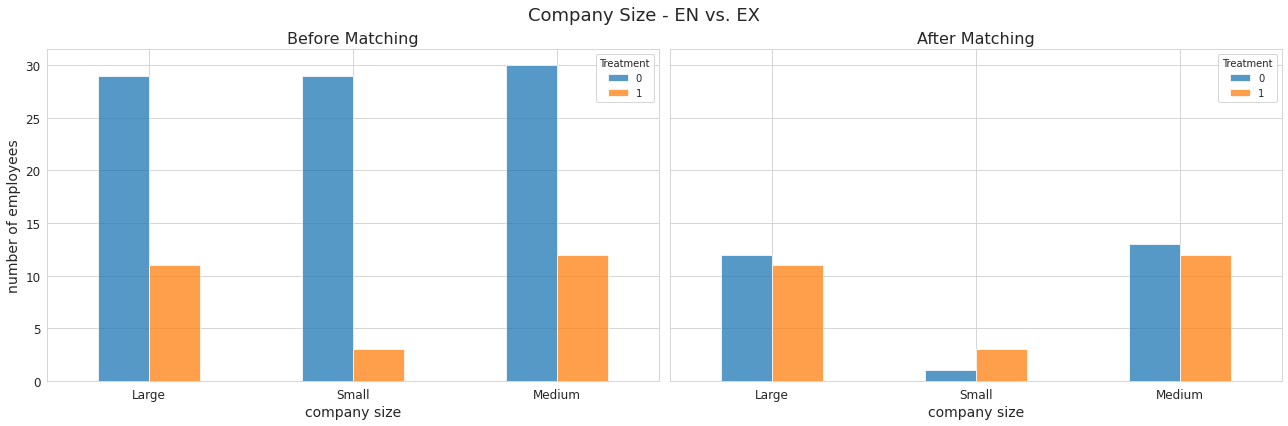

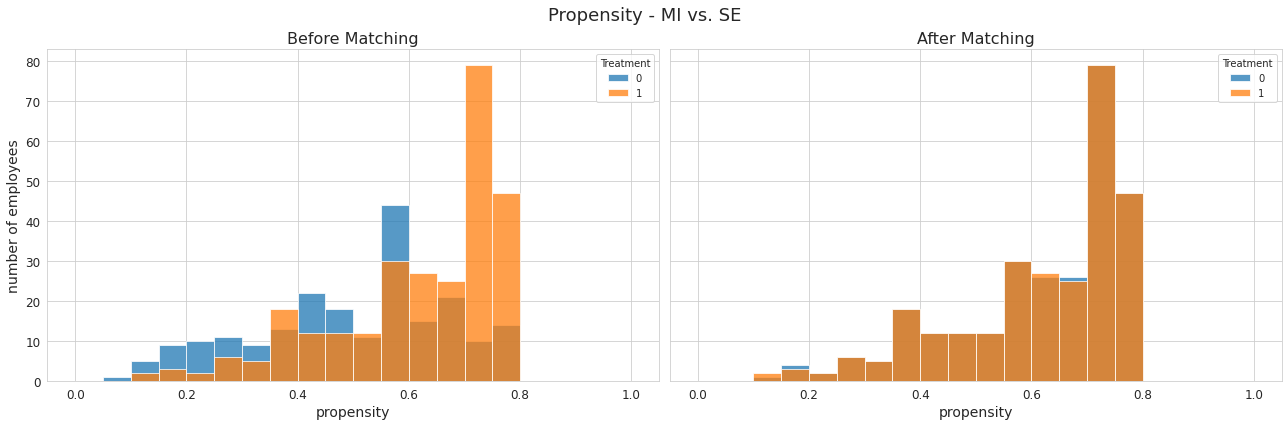

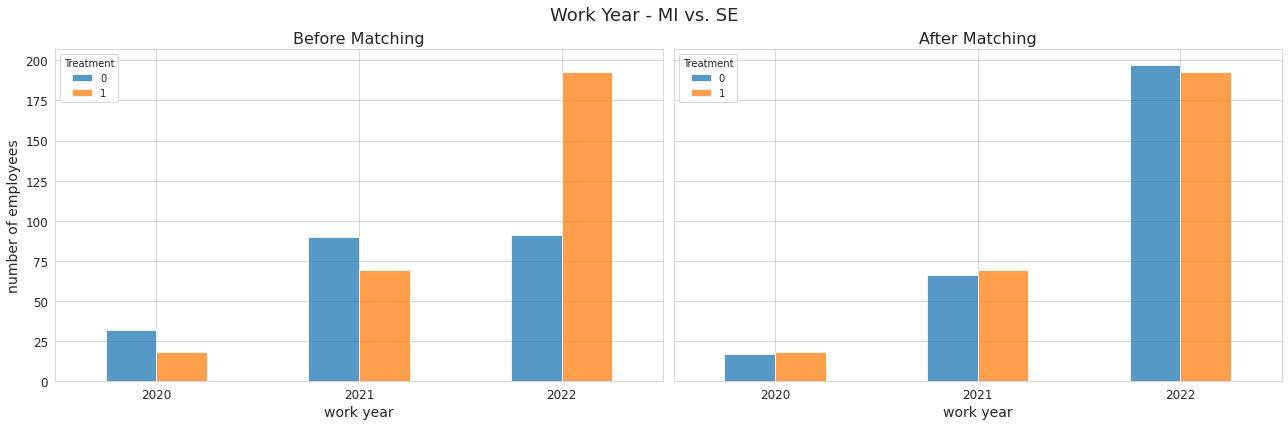

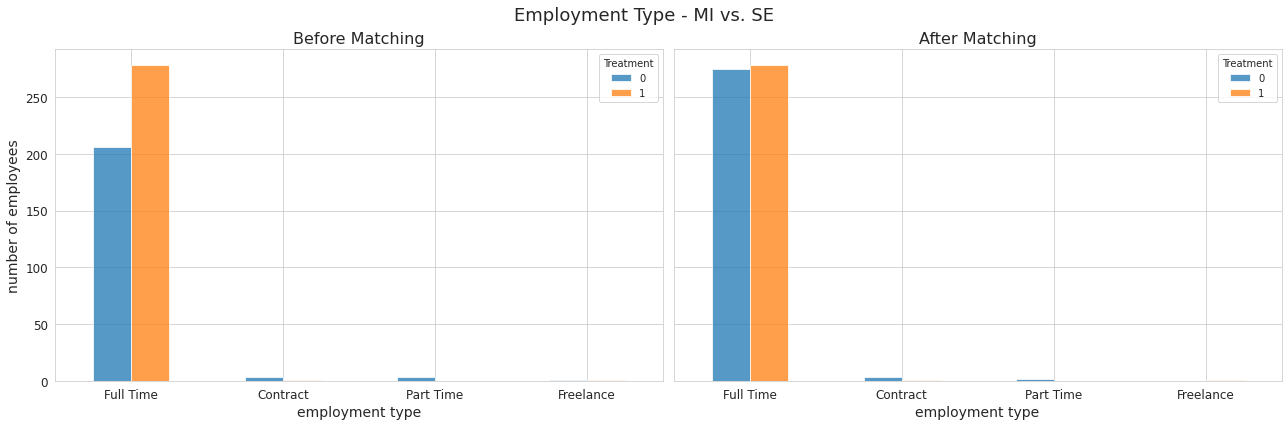

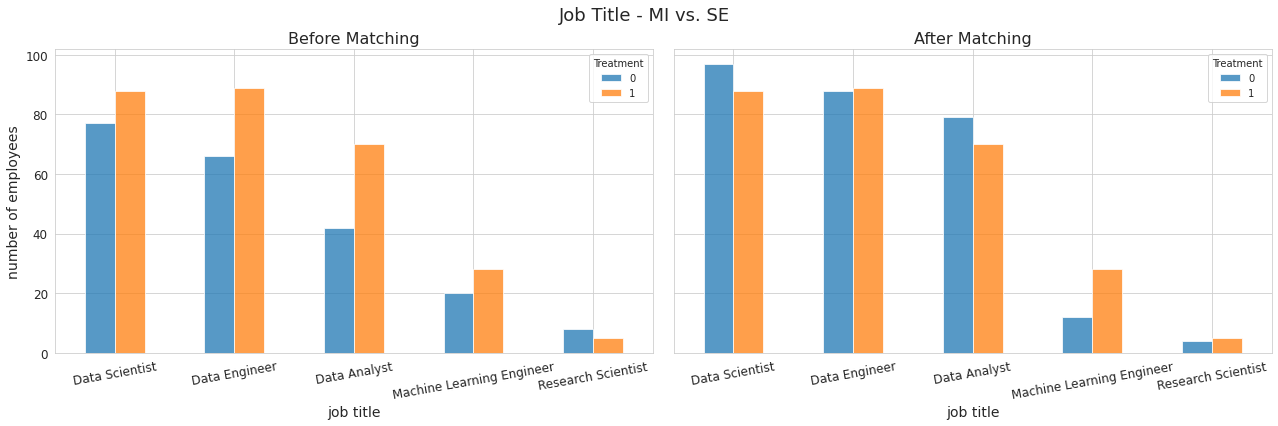

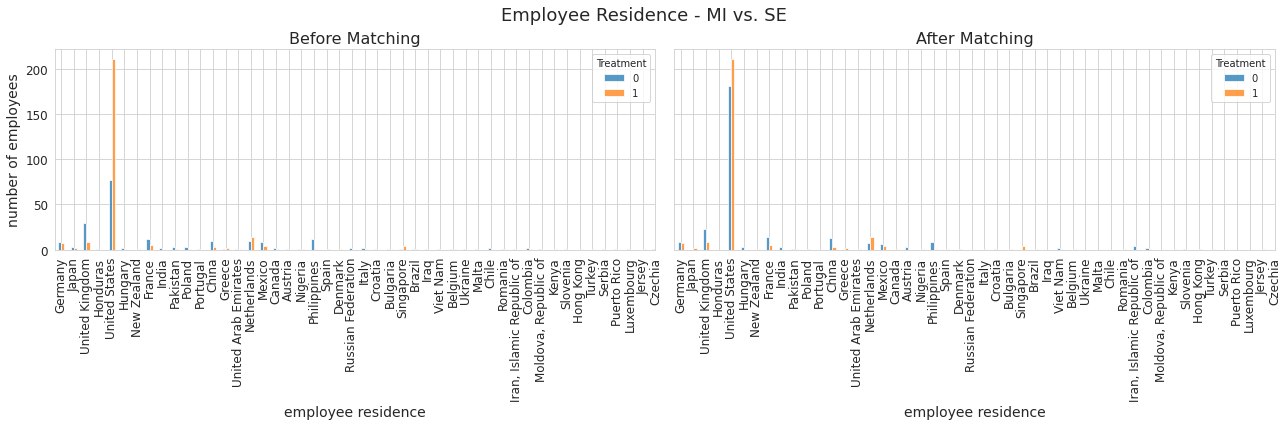

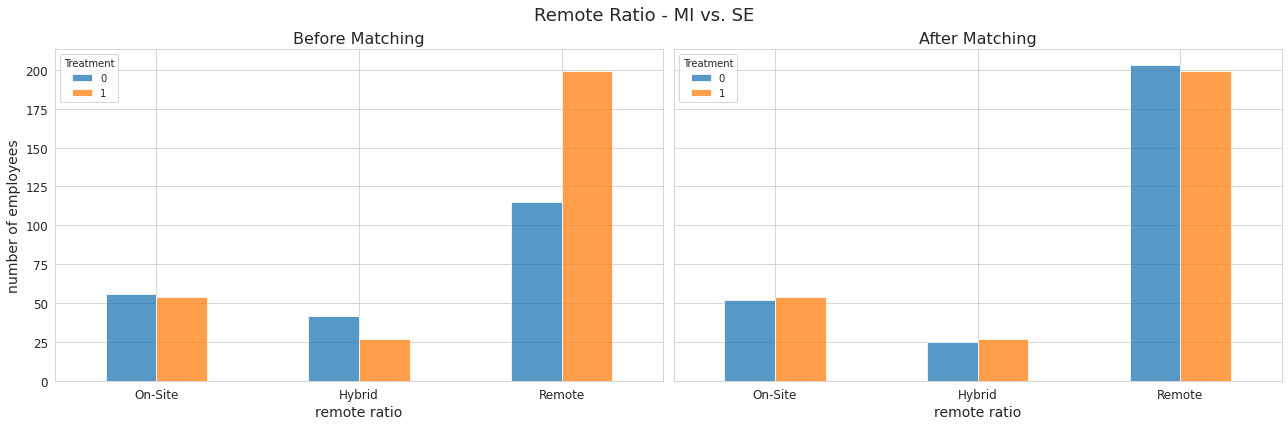

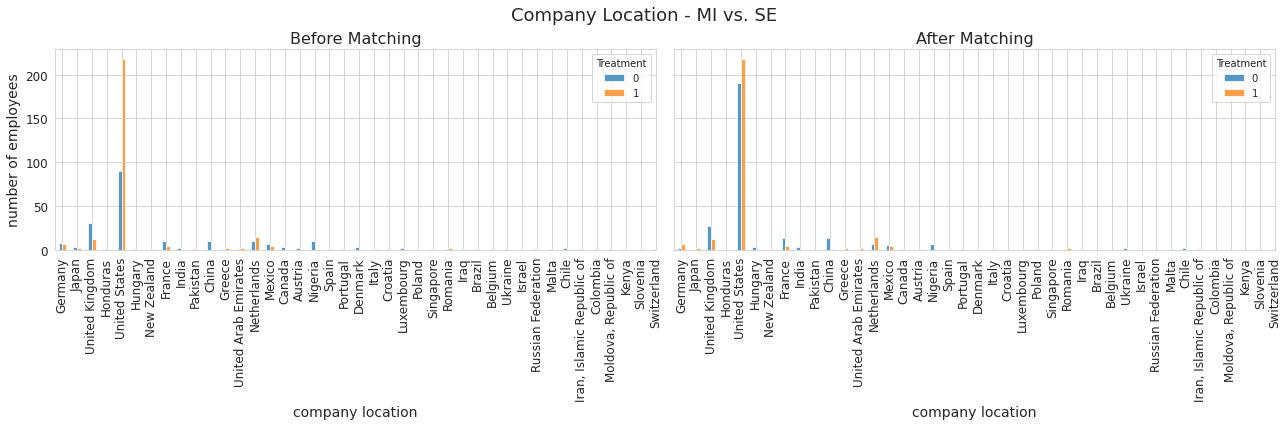

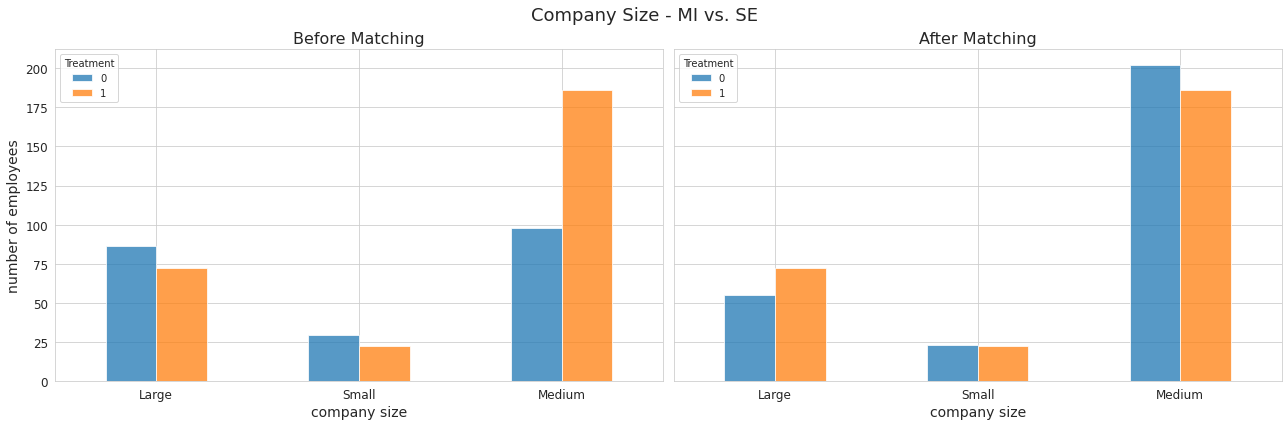

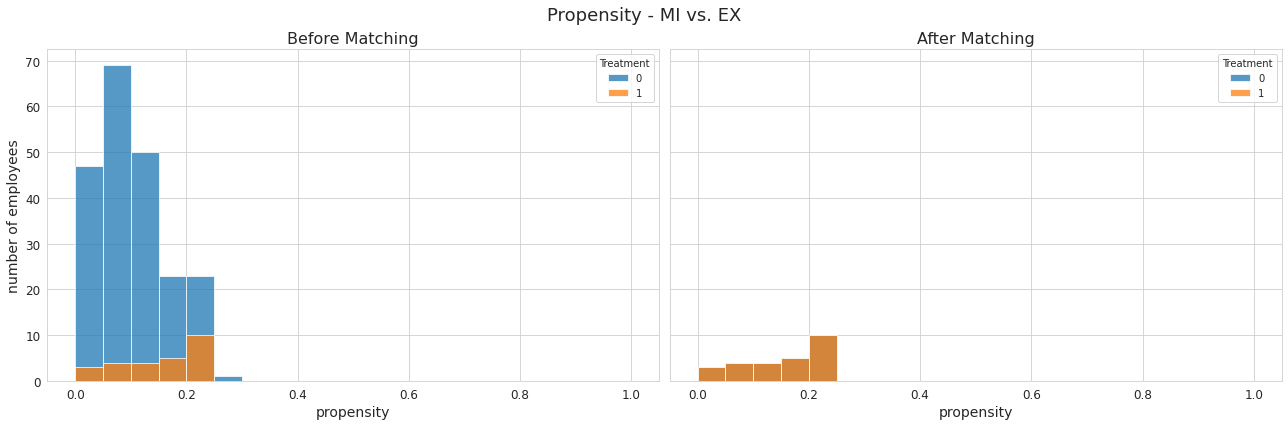

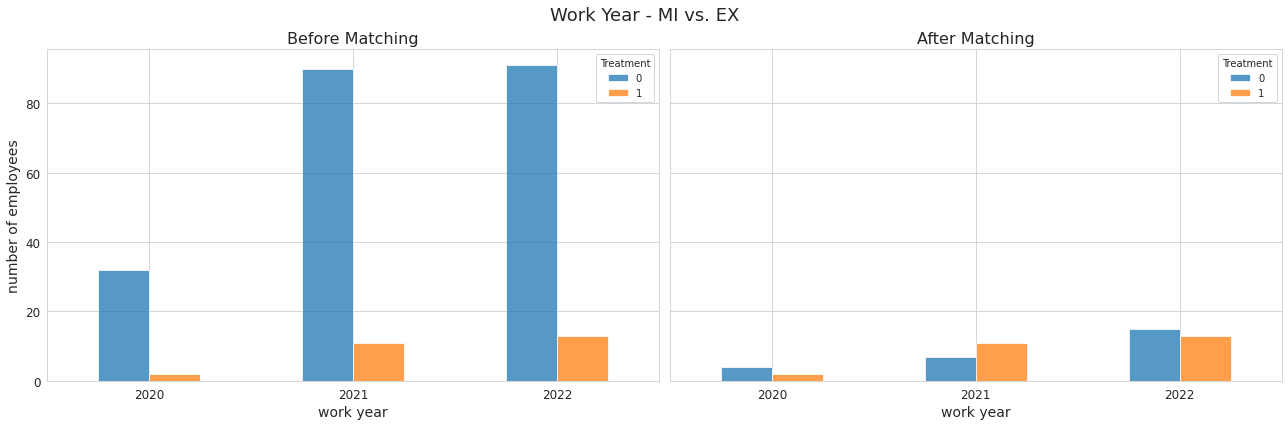

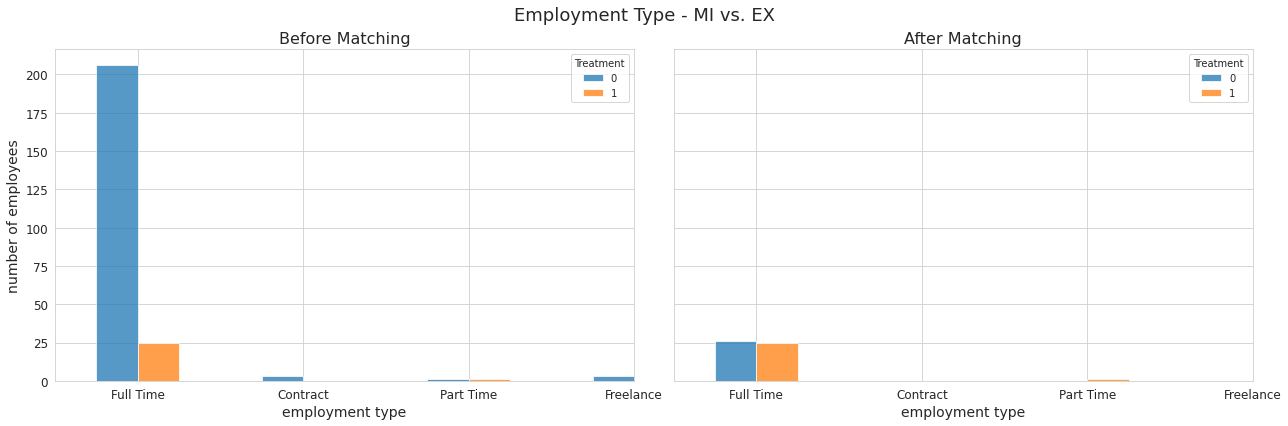

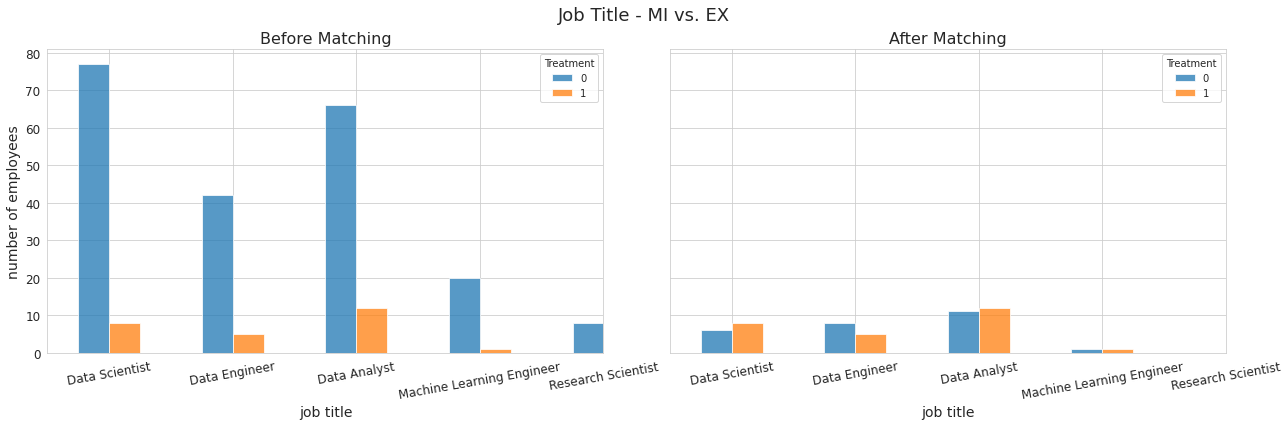

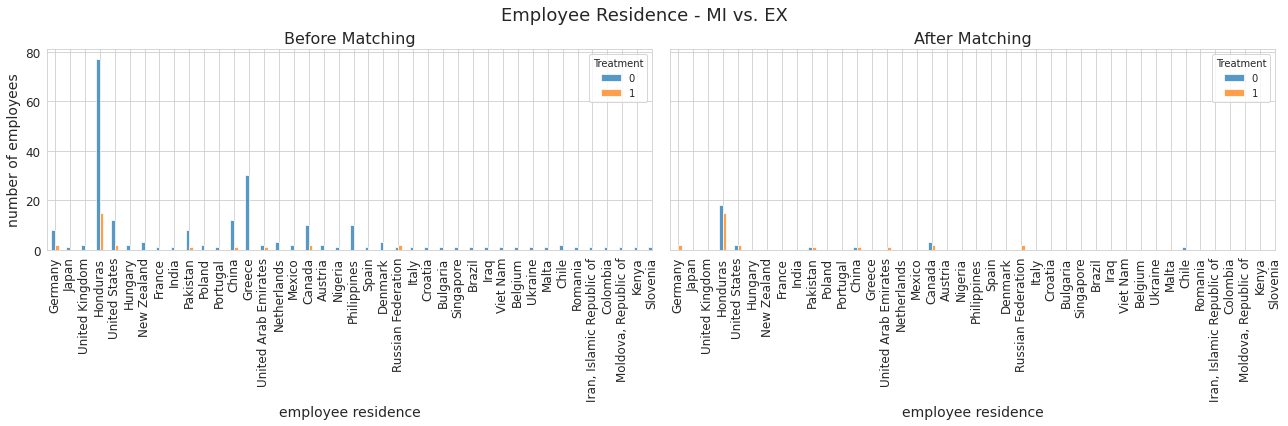

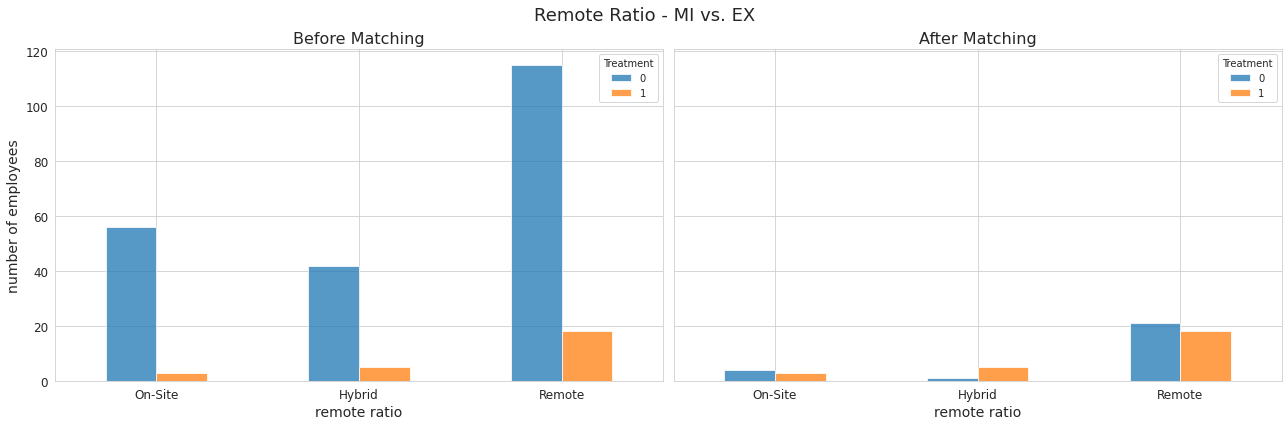

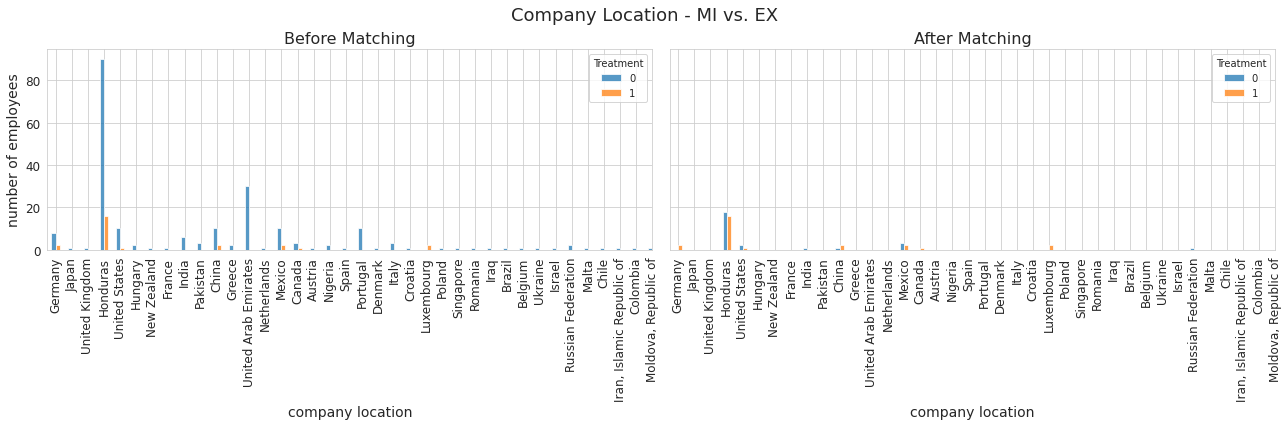

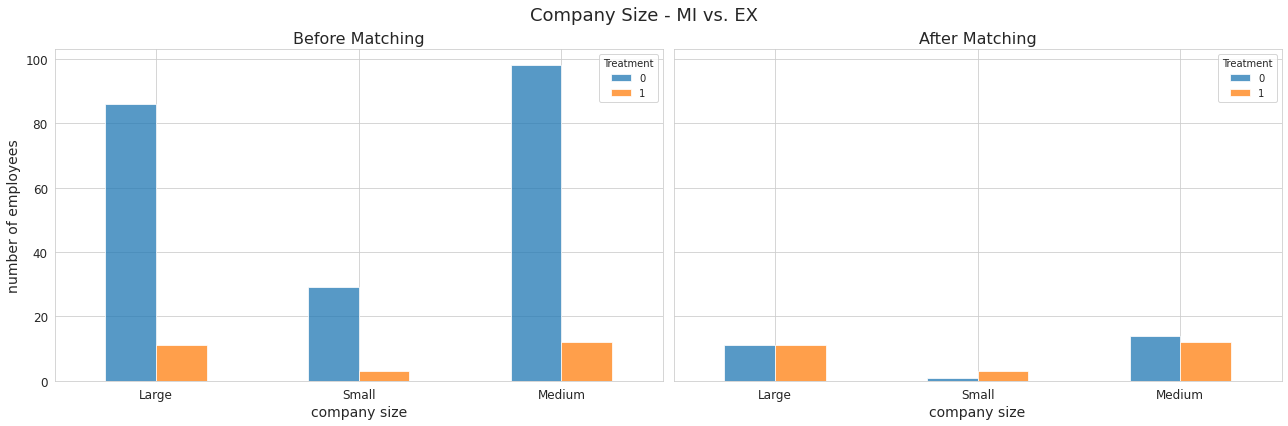

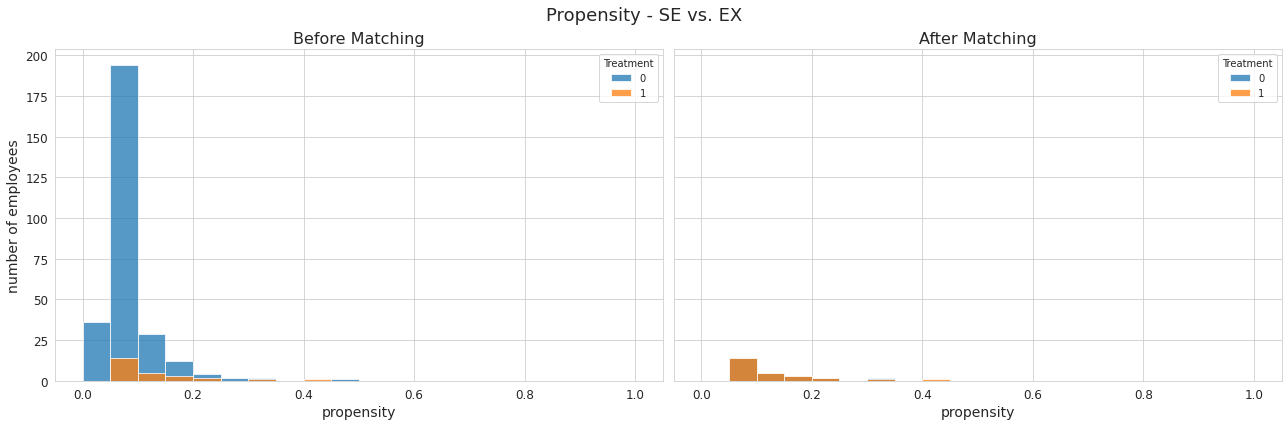

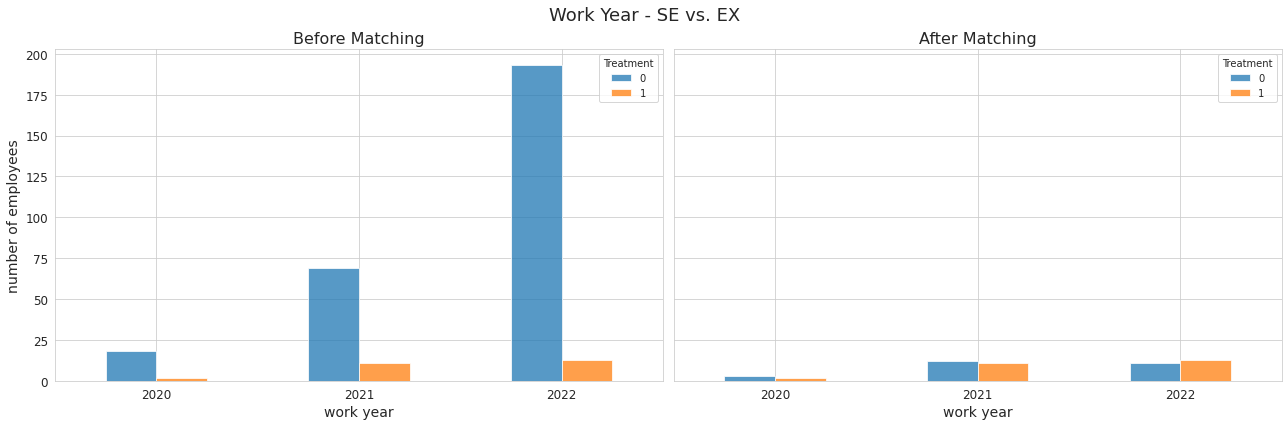

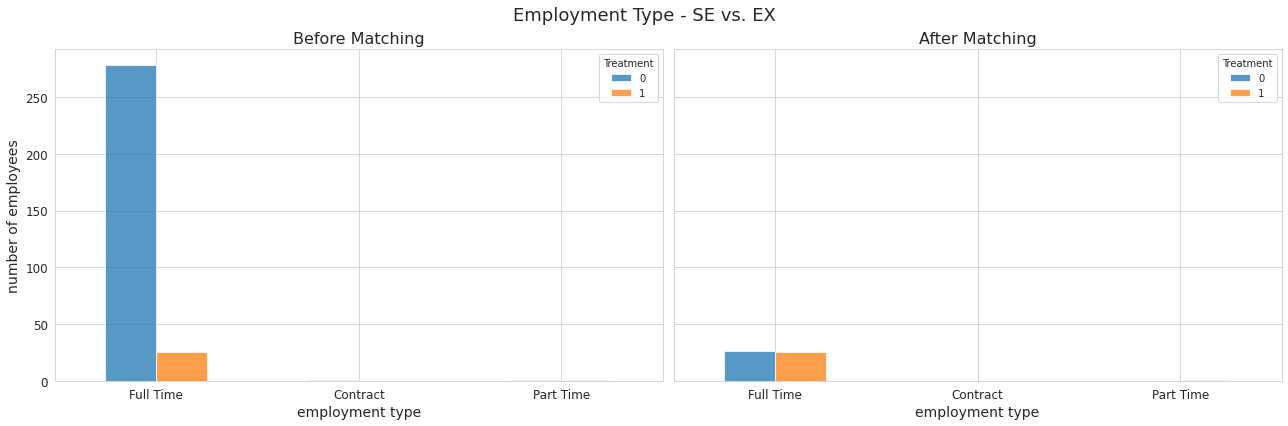

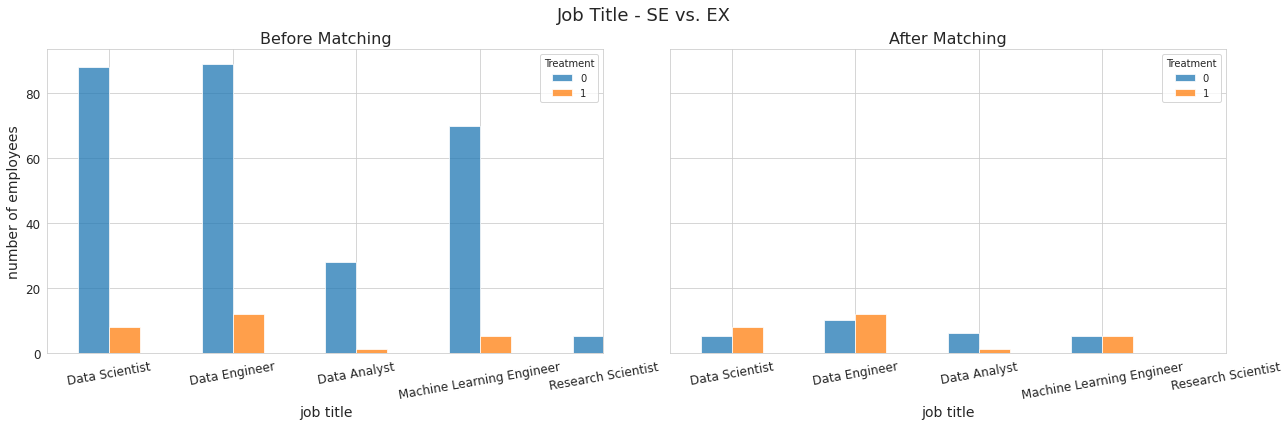

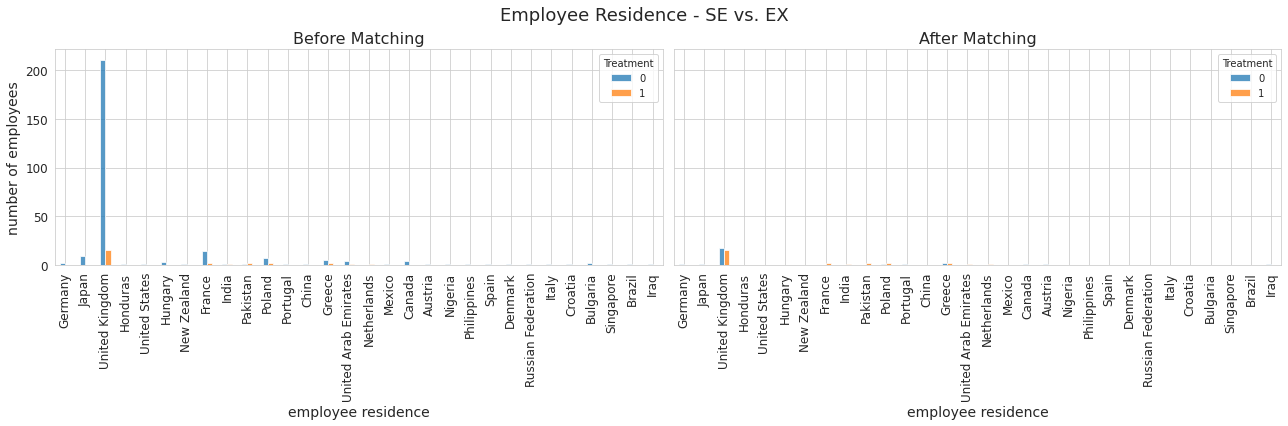

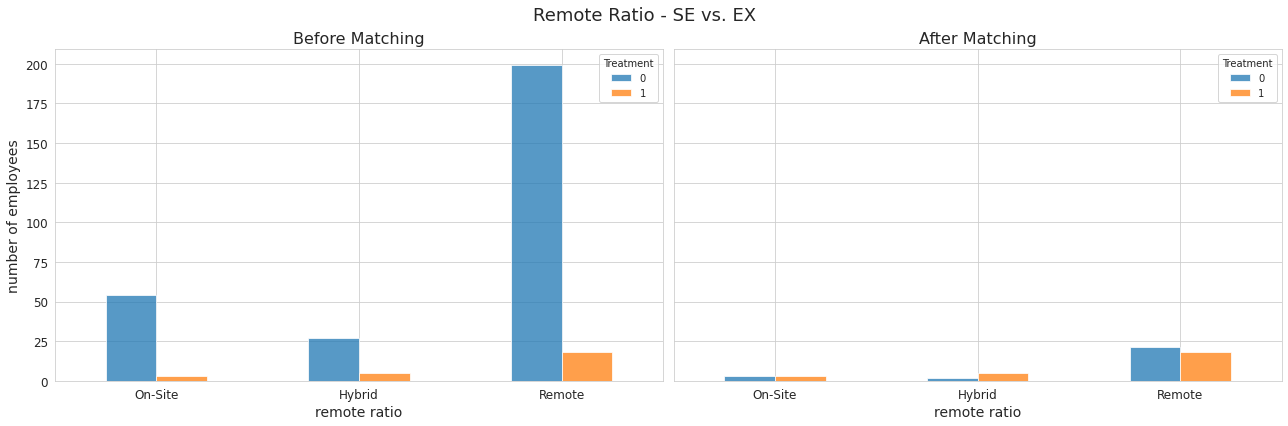

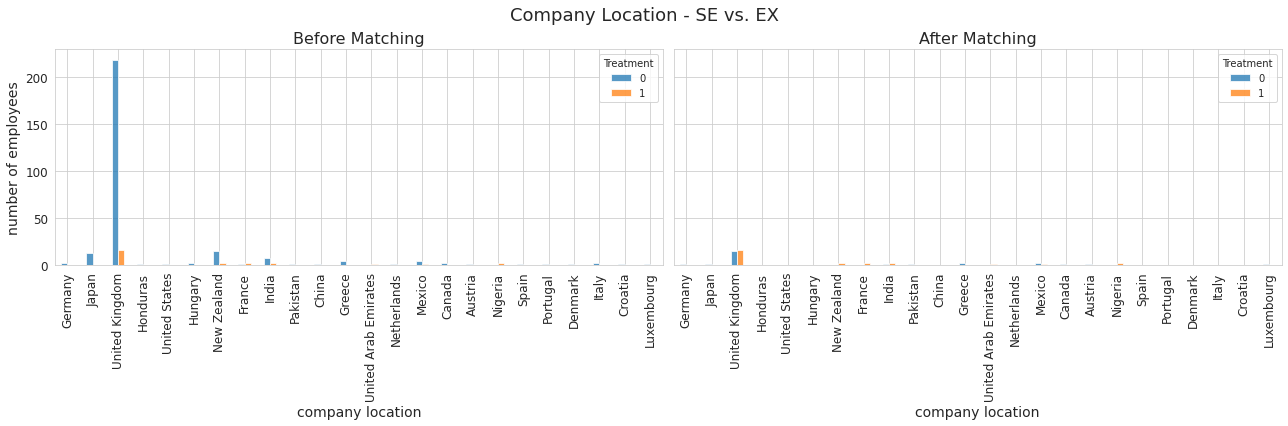

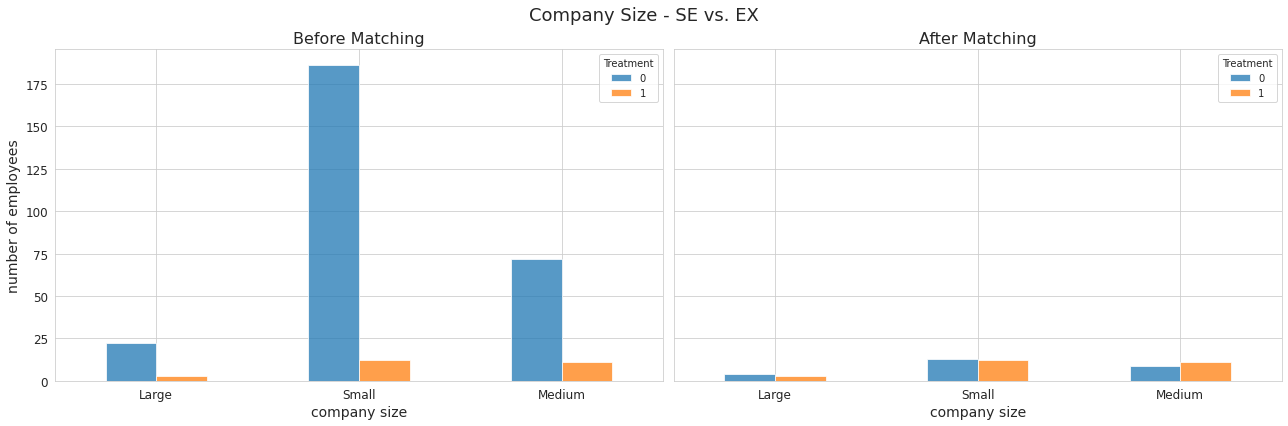

In [15]:
# Infer for propensity estimation using linear covariates - single against single
plot = [True, False, False, False, False, False]  # to plot all experiments, change all elements to True

for i, low in enumerate(LEVELS[:-1]):
    for high in LEVELS[i + 1:]:
        exp_name = f"{low}__{high}"
        results_lin[exp_name] = infer(partial_data[exp_name], treat_scheme="T", propensity_method="lin", alpha=alpha, plot=True, mapper=mapper,
                                 exp_name=exp_name)

In [16]:
# # Infer for propensity estimation using Imbens algorithm, combining linear and quadratic covariates - group against group
# results_imbens = {}
# for i, cols in enumerate(drop_cols):
#     exp_name = f"{'_'.join(LOW_LEVEL[i])}__{'_'.join(HIGH_LEVEL[i])}"
#     results_imbens[exp_name] = infer(processed_data.drop(columns=cols[1:]), treat_scheme=cols[0], propensity_method="imbens", alpha=alpha,
#                                 plot=plot[i], mapper=mapper, exp_name=exp_name)

In [17]:
# # Infer for propensity estimation using Imbens algorithm, combining linear and quadratic covariates - single against single
# for i, low in enumerate(LEVELS[:-1]):
#     for high in LEVELS[i + 1:]:
#         exp_name = f"{low}__{high}"
#         results_imbens[exp_name] = infer(partial_data[exp_name], treat_scheme="T", propensity_method="imbens", alpha=alpha, plot=False,
#                                          mapper=mapper, exp_name=exp_name)

In [18]:
# Results
stats = ("att", "atc", "ate")
for exp in results_lin:
    low, high = exp.split('__')
    print(f"Results for experiment of {', '.join(low.split('_'))} vs. {', '.join(high.split('_'))}:\n")
    # print("\tResults for linear propensity estimation:")
    for stat in stats:
        print(f"\t{stat.upper()}: {results_lin[exp][stat]:.1f} with confidence inerval {results_lin[exp][f'{stat}_conf']} at a confidence level of {int(100 * (1 - alpha))}%.")
    print("")
    # print("\n\tResults for propensity estimation using Imbens:")
    # for stat in stats:
    #     print(f"\t\t{stat.upper()}: {results_imbens[exp][stat]:.2f} with confidence inerval {results_imbens[exp][f'{stat}_conf']} at a confidence level of {int(100 * (1 - alpha))}%.")
    # print("\n")

Results for experiment of EN vs. MI, SE, EX:

	ATT: 52017.3 with confidence inerval [45158.0, 58876.7] at a confidence level of 95%.
	ATC: 42706.3 with confidence inerval [24617.2, 60795.5] at a confidence level of 95%.
	ATE: 50637.9 with confidence inerval [44204.1, 57071.8] at a confidence level of 95%.

Results for experiment of EN, MI vs. SE, EX:

	ATT: 21972.2 with confidence inerval [12918.3, 31026.0] at a confidence level of 95%.
	ATC: 50019.0 with confidence inerval [41129.5, 58908.4] at a confidence level of 95%.
	ATE: 35879.7 with confidence inerval [29436.7, 42322.7] at a confidence level of 95%.

Results for experiment of EN, MI, SE vs. EX:

	ATT: 84257.5 with confidence inerval [31880.6, 136634.3] at a confidence level of 95%.
	ATC: 106011.8 with confidence inerval [94992.1, 117031.6] at a confidence level of 95%.
	ATE: 104645.6 with confidence inerval [93794.8, 115496.4] at a confidence level of 95%.

Results for experiment of EN vs. MI:

	ATT: 24201.8 with confidence ine

In [19]:
def plot_confidence_interval(results: Dict[str, Dict[str, float]], stat: str, color: str = '#2187bb', horizontal_line_width: float = 0.2):
    """
    Plots a the confidence intervals for all experiments for a single stat - ATE, ATC, or ATT.

    Arguments:
        results:                results for all experiments and stats.
        stat:                   Name of the stat to plot.
        color:                  The color of the intervals in the plot.
        horizontal_line_width:  The width of the interval bounds in the plot.
    
    Returns:
        None
    """
    fig = plt.figure(figsize=(12, 8))
    for i, (key, value) in enumerate(results.items()):
        left = i + 1 - horizontal_line_width / 2
        right = i + 1 + horizontal_line_width / 2
        mean = value[stat]
        bottom, top = value[f"{stat}_conf"]

        plt.plot([i + 1, i + 1], [top, bottom], color=color)
        plt.plot([left, right], [top, top], color=color)
        plt.plot([left, right], [bottom, bottom], color=color)
        plt.plot(i + 1, mean, 'o', color='red')

    plt.xlabel("Experiments", fontsize=14)
    plt.xticks(range(1, len(results) + 1), [f"{', '.join(exp.split('__')[0].split('_'))} vs. {', '.join(exp.split('__')[1].split('_'))}" for exp in results.keys()], rotation=30)
    plt.ylabel("USD", fontsize=14)
    plt.ylim(0, plt.ylim()[1])
    plt.tick_params(axis='both', which='major', labelsize=13)
    plt.title(f'{stat.upper()} - Confidence Intervals for All Experiments', fontsize=18)
    fig.tight_layout()
    plt.savefig(os.path.join(FIGURES_PATH, f"{stat}_confidence_intervals.png"))
    plt.show()


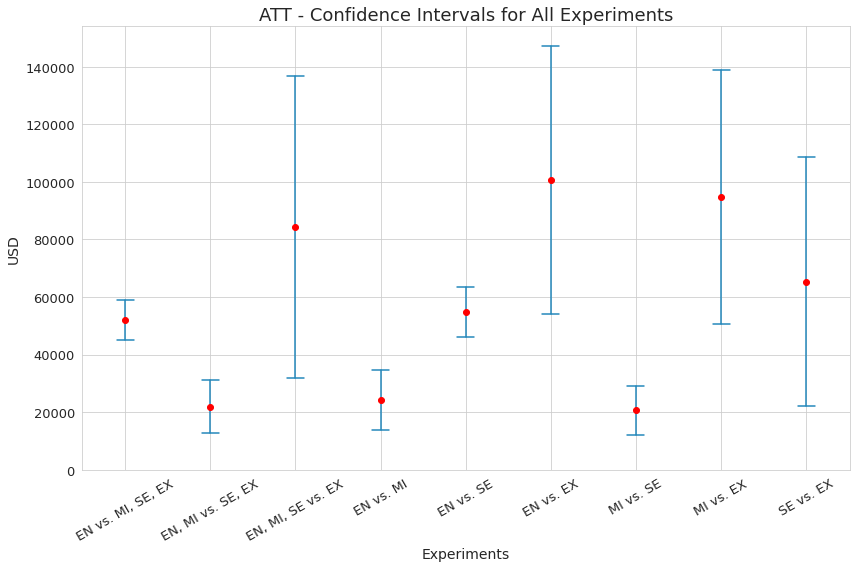

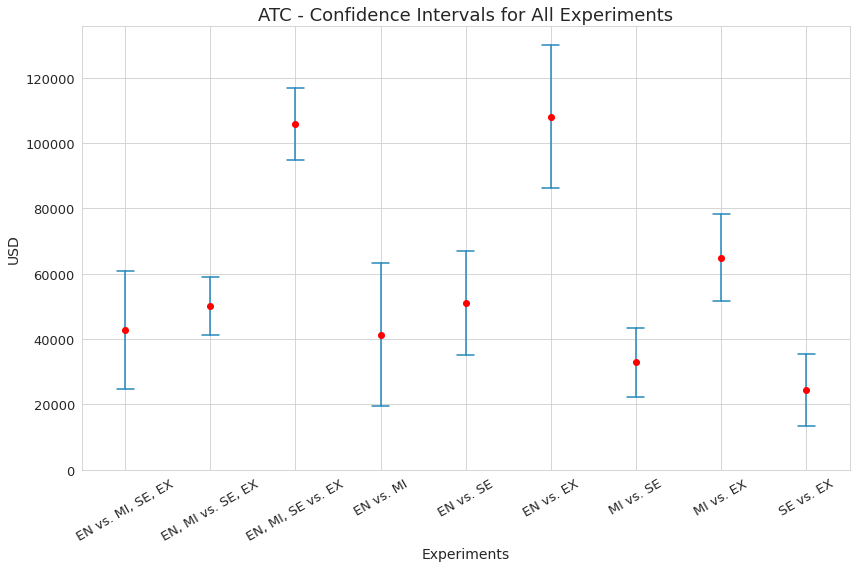

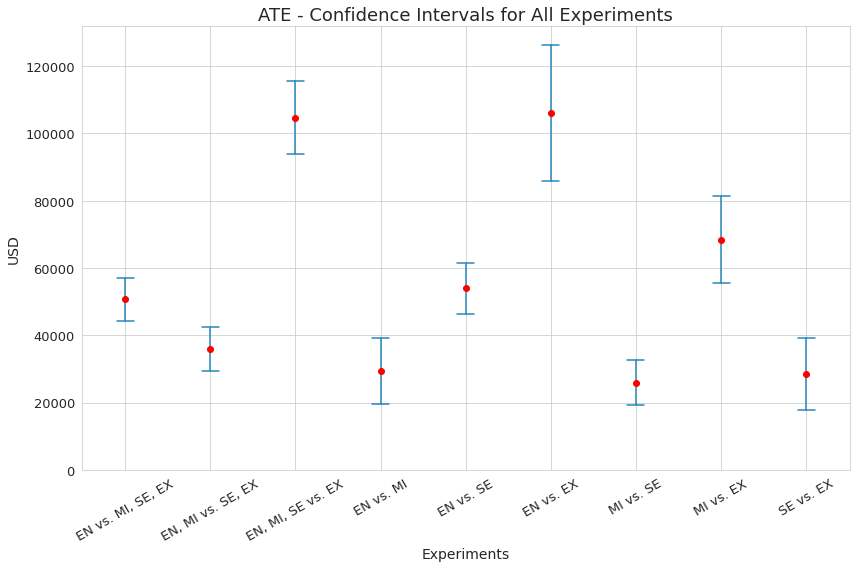

In [20]:
# plot confidence intervals for all experiments for ATT, ATC, and ATE
for stat in stats:
    plot_confidence_interval(results_lin, stat)